# Optimizing Gaze-Based Interactions in AR:
## A Systematic Analysis of Proximity Zones and Dwell Times for Reliable Target Activation

Research Overview:
This study examines the relationship between gaze intersection patterns, proximity thresholds, and dwell times to develop reliable activation parameters for gaze-based interactions in augmented reality environments.

Key Investigation Areas:
1. Distance-Based Accuracy (0-10m range)
2. Gaze Distribution Patterns
3. Intersection Density Analysis
4. Micro-Scale Precision Zones
5. Temporal Stability Patterns
6. Multi-Parameter Activation Analysis
7. Practical Implementation Framework

Research Outcomes:
- Identified optimal interaction zones (0-2m from headset)
- Established effective proximity thresholds (100-250mm)
- Determined practical dwell times (1-3s)
- Developed adaptive activation framework

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.ndimage import gaussian_filter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import io

# Set visualization preferences
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Set random seed for reproducibility
np.random.seed(42)

# Custom color palette for consistency
COLOR_PALETTE = {
    'primary': '#2196F3',    # Blue
    'secondary': '#FF4081',  # Pink
    'success': '#4CAF50',    # Green
    'warning': '#FFC107',    # Amber
    'error': '#F44336'       # Red
}

print("Setup complete!")

Setup complete!


In [2]:
# Cell 2: File upload interface
print("Please upload your study_2_debug_file.txt file:")
uploaded_debug = files.upload()
debug_content = io.StringIO(uploaded_debug[list(uploaded_debug.keys())[0]].decode('utf-8')).read()

print("\nPlease upload your advanced_metrics.txt file:")
uploaded_metrics = files.upload()
metrics_content = io.StringIO(uploaded_metrics[list(uploaded_metrics.keys())[0]].decode('utf-8')).read()

Please upload your study_2_debug_file.txt file:


Saving study_2_debug_file.txt to study_2_debug_file.txt

Please upload your advanced_metrics.txt file:


Saving advanced_metrics.txt to advanced_metrics.txt


In [5]:
def process_debug_file(content):
    """
    Process the study_2_debug_file content
    Returns a structured DataFrame with debug data
    """
    # Add brackets to make it valid JSON if needed
    if not content.startswith('['):
        content = '[' + content
    if not content.endswith(']'):
        content = content.rstrip(',') + ']'

    # Parse JSON data
    data = json.loads(content)

    processed_data = []

    for scene in data:
        scene_name = scene['SceneName']
        target_pos = scene['Target']['Position']
        target_diameter = scene['Target']['Diameter']

        # Process each gaze tracking entry
        for gaze_entry in scene['GazeTracking']:
            gaze_pos = gaze_entry['GazePosition']

            # Calculate 3D offset from target
            offset = {
                'x': gaze_pos['x'] - target_pos['x'],
                'y': gaze_pos['y'] - target_pos['y'],
                'z': gaze_pos['z'] - target_pos['z']
            }

            # Calculate absolute distance from target
            distance = np.sqrt(
                offset['x']**2 +
                offset['y']**2 +
                offset['z']**2
            )

            # Create entry for processed data
            processed_entry = {
                'scene_name': scene_name,
                'start_time': scene['StartTime'],
                'time_from_start': float(gaze_entry['TimeFromStartTrial:']),  # Note the colon
                'target_x': target_pos['x'],
                'target_y': target_pos['y'],
                'target_z': target_pos['z'],
                'target_diameter': target_diameter,
                'gaze_x': gaze_pos['x'],
                'gaze_y': gaze_pos['y'],
                'gaze_z': gaze_pos['z'],
                'offset_x': offset['x'],
                'offset_y': offset['y'],
                'offset_z': offset['z'],
                'distance_from_target': distance,
                'depth_error': gaze_entry['DepthError'],
                'fixation_stability': gaze_entry['FixationStability'],
                'is_gaze_collide': gaze_entry['IsGazeCollideWithTarget'],
                'gaze_fixation_x': gaze_entry['GazeFixationPosition']['x'],
                'gaze_fixation_y': gaze_entry['GazeFixationPosition']['y'],
                'gaze_fixation_z': gaze_entry['GazeFixationPosition']['z'],
                'gaze_fixation_diameter': gaze_entry['GazeFixationDiameter']
            }

            processed_data.append(processed_entry)

    return pd.DataFrame(processed_data)

def process_metrics_file(content):
    """
    Process the advanced_metrics content
    Returns a structured DataFrame with advanced metrics data
    """
    # Add brackets to make it valid JSON if needed
    if not content.startswith('['):
        content = '[' + content
    if not content.endswith(']'):
        content = content.rstrip(',') + ']'

    # Parse JSON data
    data = json.loads(content)

    processed_data = []

    for entry in data:
        scene_name = entry['SceneName']
        start_time = entry['StartTime']

        for metric in entry['Metrics']:
            metric_entry = metric.copy()
            metric_entry['scene_name'] = scene_name
            metric_entry['start_time'] = start_time
            processed_data.append(metric_entry)

    return pd.DataFrame(processed_data)

# Process both files
debug_df = process_debug_file(debug_content)
metrics_df = process_metrics_file(metrics_content)

# Display basic information about the processed data
print("Debug Data Shape:", debug_df.shape)
print("\nDebug Data Columns:", debug_df.columns.tolist())
print("\nFirst few rows of Debug Data:")
print(debug_df.head())

print("\nMetrics Data Shape:", metrics_df.shape)
print("\nMetrics Data Columns:", metrics_df.columns.tolist())
print("\nFirst few rows of Metrics Data:")
print(metrics_df.head())

Debug Data Shape: (95374, 21)

Debug Data Columns: ['scene_name', 'start_time', 'time_from_start', 'target_x', 'target_y', 'target_z', 'target_diameter', 'gaze_x', 'gaze_y', 'gaze_z', 'offset_x', 'offset_y', 'offset_z', 'distance_from_target', 'depth_error', 'fixation_stability', 'is_gaze_collide', 'gaze_fixation_x', 'gaze_fixation_y', 'gaze_fixation_z', 'gaze_fixation_diameter']

First few rows of Debug Data:
  scene_name             start_time  time_from_start  target_x  target_y  \
0         01  12/14/2024 3:17:46 PM         0.016743     -0.32     -0.04   
1         01  12/14/2024 3:17:46 PM         0.033458     -0.32     -0.04   
2         01  12/14/2024 3:17:46 PM         0.049715     -0.32     -0.04   
3         01  12/14/2024 3:17:46 PM         0.067018     -0.32     -0.04   
4         01  12/14/2024 3:17:46 PM         0.082910     -0.32     -0.04   

   target_z  target_diameter  gaze_x  gaze_y  gaze_z  ...  offset_y  offset_z  \
0     1.205            0.066   0.001   0.006  -0

# 1. Distance-Based Accuracy Analysis: Identifying Optimal Interaction Ranges

This analysis examines how gaze interaction accuracy varies with distance from the AR headset to the target object. Understanding this relationship is crucial for designing effective gaze-based interactions in AR spaces.

## Key Findings:
- Optimal Interaction Zone (0-2m):
  * Highest accuracy with mean error of 16.5-57.6cm
  * Most stable fixation performance
  * Recommended for precise interactions

- Workable Zone (2-4m):
  * Moderate accuracy with ~1.5m mean error
  * Suitable for larger targets
  * Consider increased activation zones

- Performance Degradation (4m+):
  * Significant accuracy drop-off
  * Error exceeds 3-8m
  * Not recommended for precise interactions

## Visualization Components:
1. Gaze Error vs Distance: Raw error distribution showing accuracy degradation
2. Error Distribution by Range: Boxplot showing error patterns across distance bins
3. Success Rate Analysis: Sharp decline in success rate beyond 2m
4. Intersection Density: Heat map showing concentration of successful interactions

## Design Implications:
- Prioritize interactive elements within 0-2m range
- Implement distance-adaptive interaction zones
- Consider distance constraints when designing AR interfaces


Accuracy Statistics by Distance Range:
             gaze_error               fixation_stability
                   mean median    std               mean
distance_bin                                            
0-1m              0.165  0.096  0.566              0.002
1-2m              0.576  0.375  0.906              0.002
2-3m              1.509  1.068  1.985              0.004
3-4m              1.461  1.201  1.988              0.004
4-5m              2.926  2.146  4.416              0.004
5-6m              3.505  3.655  3.486              0.005
6-7m              4.941  5.173  2.890              0.004
7-8m              5.922  6.231  3.857              0.004
8-9m              8.111  8.129  0.054              0.006
9-10m             8.253  8.690  2.260              0.004


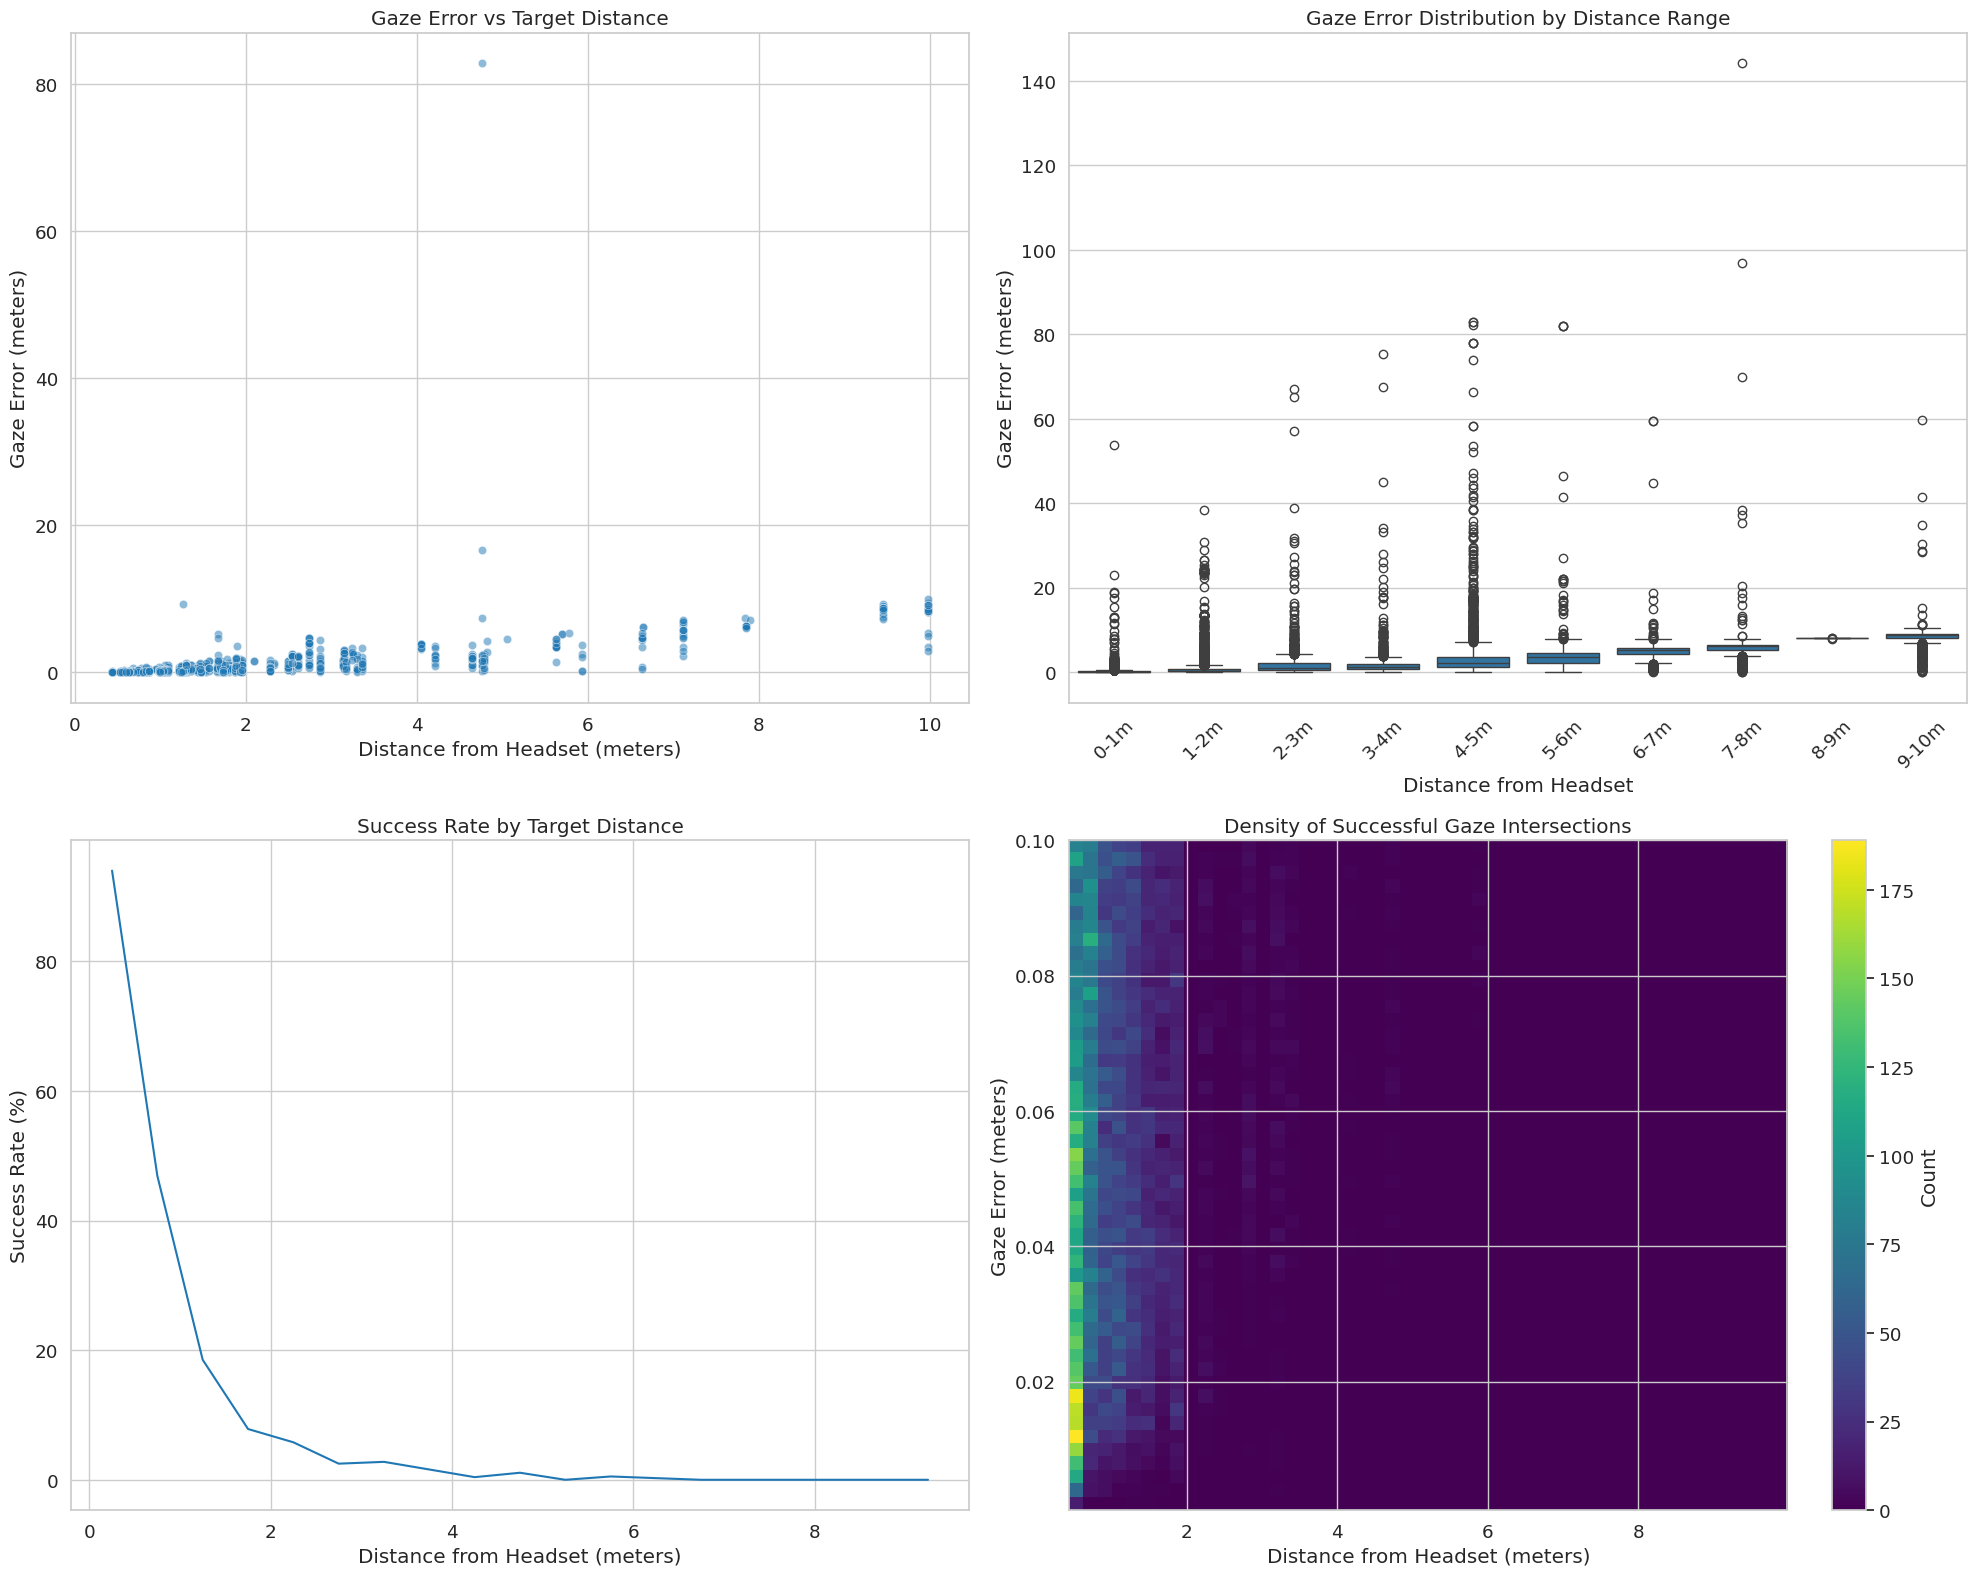

In [19]:
def analyze_distance_accuracy(debug_df, proximity_threshold=0.1, dwell_threshold=1.0):
    """
    Analyze gaze accuracy relative to target distance from headset
    """
    # Calculate absolute distance from headset to target for each frame
    debug_df['target_distance_from_headset'] = np.sqrt(
        debug_df['target_x']**2 +
        debug_df['target_y']**2 +
        debug_df['target_z']**2
    )

    # Calculate gaze accuracy metrics
    debug_df['gaze_error'] = np.sqrt(
        debug_df['relative_gaze_x']**2 +
        debug_df['relative_gaze_y']**2 +
        debug_df['relative_gaze_z']**2
    )

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Scatter plot of gaze error vs target distance
    sns.scatterplot(
        data=debug_df.sample(1000),  # Sample for clarity
        x='target_distance_from_headset',
        y='gaze_error',
        alpha=0.5,
        ax=ax1
    )
    ax1.set_title('Gaze Error vs Target Distance')
    ax1.set_xlabel('Distance from Headset (meters)')
    ax1.set_ylabel('Gaze Error (meters)')

    # Plot 2: Box plot of gaze error by distance bins
    debug_df['distance_bin'] = pd.cut(
        debug_df['target_distance_from_headset'],
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        labels=['0-1m', '1-2m', '2-3m', '3-4m', '4-5m', '5-6m', '6-7m', '7-8m', '8-9m', '9-10m']
    )

    sns.boxplot(
        data=debug_df,
        x='distance_bin',
        y='gaze_error',
        ax=ax2
    )
    ax2.set_title('Gaze Error Distribution by Distance Range')
    ax2.set_xlabel('Distance from Headset')
    ax2.set_ylabel('Gaze Error (meters)')
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Success rate by distance
    success_rates = []
    distance_bins = np.arange(0, 10, 0.5)  # 0.5m bins

    for i in range(len(distance_bins)-1):
        bin_data = debug_df[
            (debug_df['target_distance_from_headset'] >= distance_bins[i]) &
            (debug_df['target_distance_from_headset'] < distance_bins[i+1])
        ]
        if len(bin_data) > 0:
            success_rate = (bin_data['gaze_error'] <= proximity_threshold).mean() * 100
            success_rates.append({
                'distance': (distance_bins[i] + distance_bins[i+1]) / 2,
                'success_rate': success_rate
            })

    success_df = pd.DataFrame(success_rates)
    sns.lineplot(
        data=success_df,
        x='distance',
        y='success_rate',
        ax=ax3
    )
    ax3.set_title('Success Rate by Target Distance')
    ax3.set_xlabel('Distance from Headset (meters)')
    ax3.set_ylabel('Success Rate (%)')
    ax3.grid(True)

    # Plot 4: Heatmap of successful dwells
    successful_dwells = debug_df[debug_df['gaze_error'] <= proximity_threshold]

    heatmap_data, xedges, yedges = np.histogram2d(
        successful_dwells['target_distance_from_headset'],
        successful_dwells['gaze_error'],
        bins=50
    )

    im = ax4.imshow(heatmap_data.T,
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    origin='lower',
                    aspect='auto',
                    cmap='viridis')

    ax4.set_title('Density of Successful Gaze Intersections')
    ax4.set_xlabel('Distance from Headset (meters)')
    ax4.set_ylabel('Gaze Error (meters)')
    plt.colorbar(im, ax=ax4, label='Count')

    plt.tight_layout()

    # Calculate summary statistics by distance range
    summary_stats = debug_df.groupby('distance_bin').agg({
        'gaze_error': ['mean', 'median', 'std'],
        'fixation_stability': 'mean'
    }).round(3)

    return summary_stats

# Run the analysis
summary_stats = analyze_distance_accuracy(debug_df)

print("\nAccuracy Statistics by Distance Range:")
print(summary_stats)

# 2. Gaze Distribution Analysis: Understanding Natural Gaze Behavior

This analysis examines how users' gaze naturally distributes around target objects, providing insights into typical gaze patterns and potential activation zone designs.

## Key Metrics:
- Average Gaze Distance: 2.318m from target
- Median Distance: 1.677m from target
- Variance (std): 1.999m
- 95th percentile: 7.117m

## Visualization Components:
1. Distance Distribution:
   * Majority of gaze points cluster within 0-2m from target
   * Secondary clusters appear at 4m and 6m intervals
   * Shows natural tendency for closer-range interactions

2. X-Y Plane Distribution:
   * Demonstrates gaze spread around target center
   * Shows slight systematic offsets in gaze patterns
   * Helps inform activation zone shape design

3. Temporal Stability:
   * Depth error patterns over time in single scene
   * Shows natural gaze stability characteristics
   * Reveals potential timing considerations for activation

4. Fixation Analysis:
   * Relationship between distance and stability
   * Helps determine optimal activation parameters
   * Guides stability threshold decisions

## Design Implications:
- Consider natural gaze spread when designing activation zones
- Account for systematic offsets in gaze patterns
- Balance activation zone size with interaction distance

Distance Statistics:
mean_distance: 2.318 meters
median_distance: 1.677 meters
std_distance: 1.999 meters
95th_percentile: 7.117 meters

Success Rates for Different Activation Zones:
50mm_zone: 0.0%
100mm_zone: 0.0%
150mm_zone: 0.0%
200mm_zone: 0.0%
250mm_zone: 0.0%
300mm_zone: 0.0%


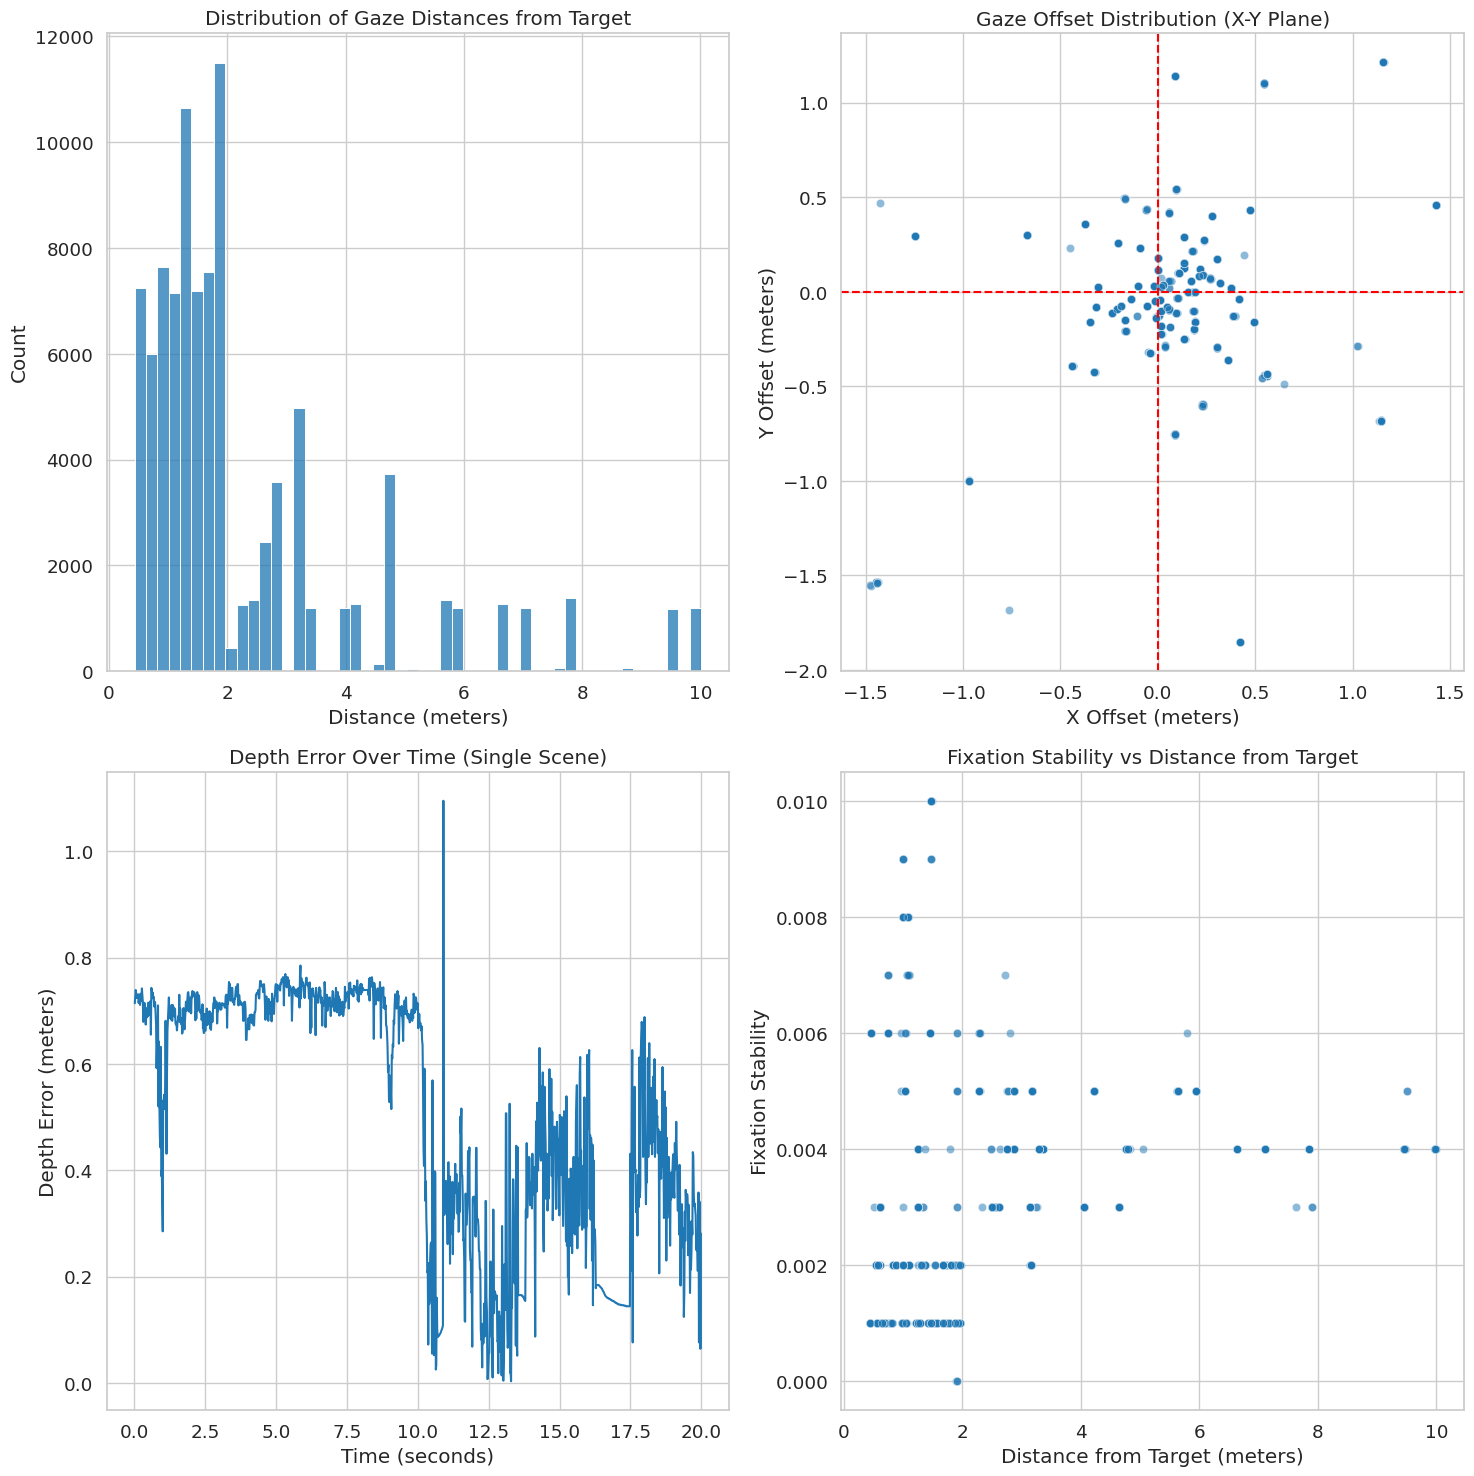

In [6]:
def analyze_gaze_patterns(debug_df):
    """
    Analyze gaze patterns relative to targets
    """
    # Calculate basic statistics for distance from target
    distance_stats = {
        'mean_distance': debug_df['distance_from_target'].mean(),
        'median_distance': debug_df['distance_from_target'].median(),
        'std_distance': debug_df['distance_from_target'].std(),
        '95th_percentile': debug_df['distance_from_target'].quantile(0.95)
    }

    # Calculate success rate for different potential activation zones
    potential_zones = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # in meters
    success_rates = {}

    for zone in potential_zones:
        within_zone = (debug_df['distance_from_target'] <= zone).mean()
        success_rates[f'{zone*1000:.0f}mm_zone'] = within_zone * 100

    return distance_stats, success_rates

def plot_gaze_distribution(debug_df):
    """
    Create visualizations of gaze distribution patterns
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Plot 1: Distribution of distances from target
    sns.histplot(data=debug_df, x='distance_from_target', bins=50, ax=axes[0,0])
    axes[0,0].set_title('Distribution of Gaze Distances from Target')
    axes[0,0].set_xlabel('Distance (meters)')

    # Plot 2: Scatter plot of gaze positions relative to target (X-Y plane)
    sns.scatterplot(data=debug_df.sample(1000), x='offset_x', y='offset_y',
                   alpha=0.5, ax=axes[0,1])
    axes[0,1].set_title('Gaze Offset Distribution (X-Y Plane)')
    axes[0,1].set_xlabel('X Offset (meters)')
    axes[0,1].set_ylabel('Y Offset (meters)')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].axvline(x=0, color='r', linestyle='--')

    # Plot 3: Depth error over time for a single scene
    single_scene = debug_df[debug_df['scene_name'] == debug_df['scene_name'].iloc[0]]
    sns.lineplot(data=single_scene, x='time_from_start', y='depth_error', ax=axes[1,0])
    axes[1,0].set_title('Depth Error Over Time (Single Scene)')
    axes[1,0].set_xlabel('Time (seconds)')
    axes[1,0].set_ylabel('Depth Error (meters)')

    # Plot 4: Fixation stability vs distance from target
    sns.scatterplot(data=debug_df.sample(1000), x='distance_from_target',
                   y='fixation_stability', alpha=0.5, ax=axes[1,1])
    axes[1,1].set_title('Fixation Stability vs Distance from Target')
    axes[1,1].set_xlabel('Distance from Target (meters)')
    axes[1,1].set_ylabel('Fixation Stability')

    plt.tight_layout()
    plt.show()

# Run analyses
distance_stats, success_rates = analyze_gaze_patterns(debug_df)

print("Distance Statistics:")
for key, value in distance_stats.items():
    print(f"{key}: {value:.3f} meters")

print("\nSuccess Rates for Different Activation Zones:")
for zone, rate in success_rates.items():
    print(f"{zone}: {rate:.1f}%")

# Create visualizations
plot_gaze_distribution(debug_df)

# 3. Gaze Intersection Analysis: Mapping the Precision Zone

This analysis examines how gaze intersections cluster around target objects in 3D space, providing crucial insights for designing activation zones that account for natural gaze behavior.

## Key Findings:
Standard Deviations by Axis:
- X-axis (horizontal): 389mm
- Y-axis (vertical): 550mm
- Z-axis (depth): 2,596mm
- Mean 3D offset: 765mm

## Visualization Components:
1. Top View (X-Z Plane):
   * Shows horizontal spread of gaze intersections
   * Reveals any systematic lateral offset patterns
   * Demonstrates depth variation in gaze targeting

2. Side View (Y-Z Plane):
   * Illustrates vertical distribution of gaze points
   * Shows relationship between elevation and depth
   * Helps understand vertical offset patterns

## Key Observations:
- Depth (Z-axis) shows the largest variation (2.6m)
- Horizontal precision is best (389mm spread)
- Vertical precision is moderate (550mm spread)
- Clear clustering pattern around target center

## Design Implications:
- Consider asymmetric activation zones:
  * Tighter in horizontal plane
  * More forgiving in depth
  * Moderate in vertical plane
- Account for systematic offsets in placement
- Design for natural gaze spread patterns


Gaze Intersection Spread Statistics:
x_std: 0.389 meters
y_std: 0.550 meters
z_std: 2.596 meters
mean_offset: 0.765 meters


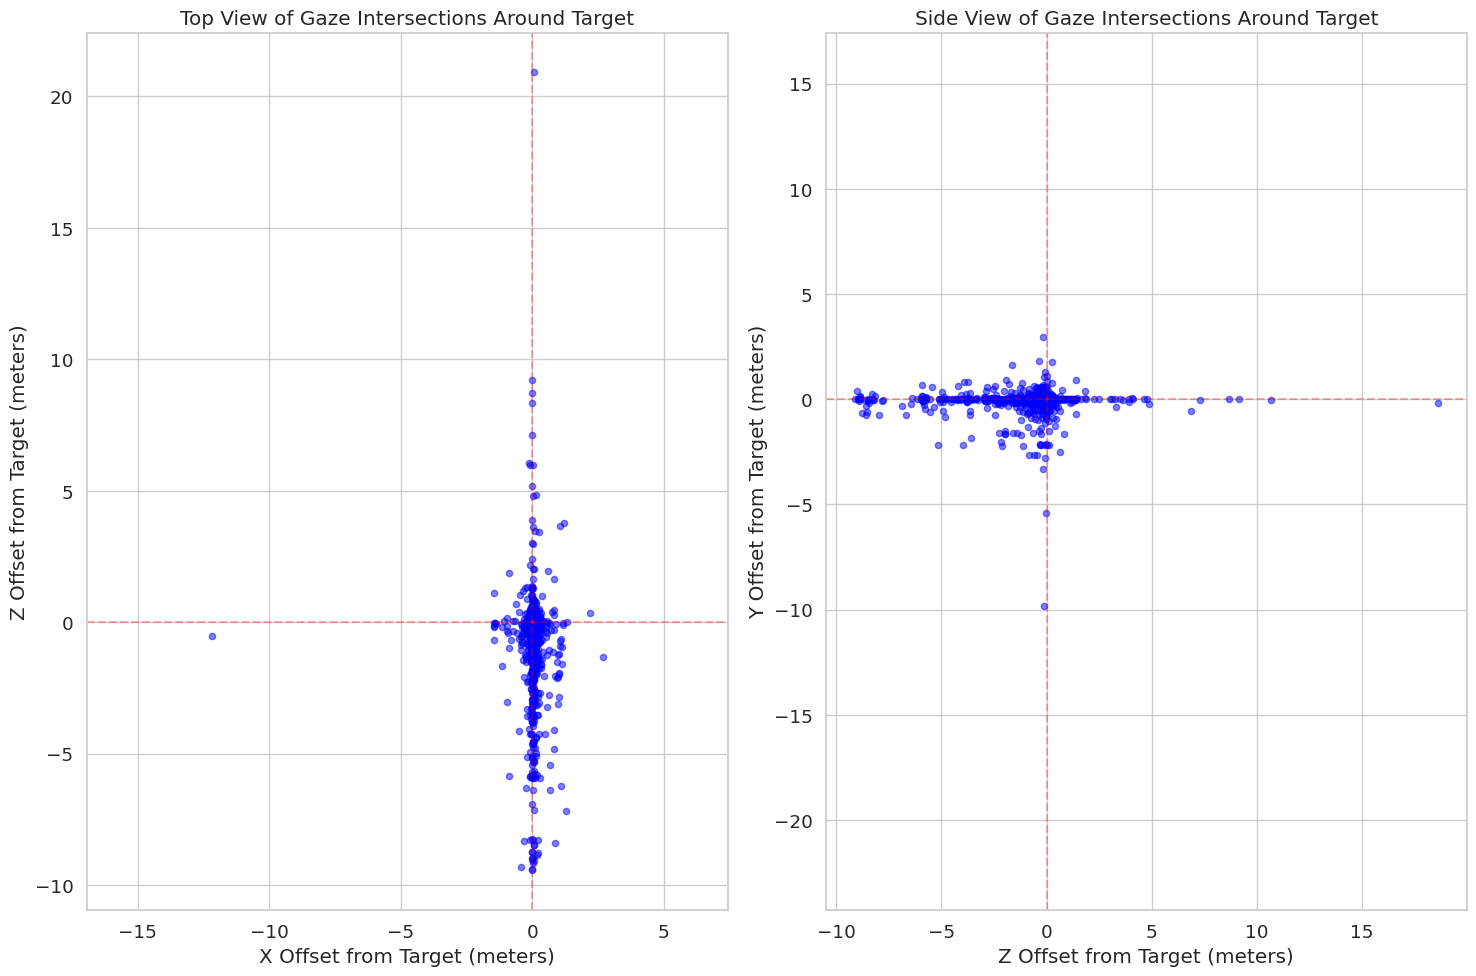

In [8]:
def analyze_gaze_target_intersections(debug_df):
    """
    Analyze how gaze intersections cluster around target objects
    """
    # Normalize gaze positions relative to target position (making target the origin)
    debug_df['relative_gaze_x'] = debug_df['gaze_fixation_x'] - debug_df['target_x']
    debug_df['relative_gaze_y'] = debug_df['gaze_fixation_y'] - debug_df['target_y']
    debug_df['relative_gaze_z'] = debug_df['gaze_fixation_z'] - debug_df['target_z']

    # Create visualization
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Top view (X-Z plane)
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(debug_df['relative_gaze_x'].sample(1000),
                         debug_df['relative_gaze_z'].sample(1000),
                         alpha=0.5, c='blue', s=20)

    # Draw target
    target_circle = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                             color='red', fill=False)
    ax1.add_patch(target_circle)

    ax1.set_title('Top View of Gaze Intersections Around Target')
    ax1.set_xlabel('X Offset from Target (meters)')
    ax1.set_ylabel('Z Offset from Target (meters)')
    ax1.grid(True)
    ax1.axis('equal')  # Make circles look circular

    # Add crosshairs at target center
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    # Plot 2: Side view (Y-Z plane)
    ax2 = fig.add_subplot(122)
    scatter = ax2.scatter(debug_df['relative_gaze_z'].sample(1000),
                         debug_df['relative_gaze_y'].sample(1000),
                         alpha=0.5, c='blue', s=20)

    # Draw target
    target_circle = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                             color='red', fill=False)
    ax2.add_patch(target_circle)

    ax2.set_title('Side View of Gaze Intersections Around Target')
    ax2.set_xlabel('Z Offset from Target (meters)')
    ax2.set_ylabel('Y Offset from Target (meters)')
    ax2.grid(True)
    ax2.axis('equal')

    # Add crosshairs at target center
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Calculate statistics about the spread
    spread_stats = {
        'x_std': debug_df['relative_gaze_x'].std(),
        'y_std': debug_df['relative_gaze_y'].std(),
        'z_std': debug_df['relative_gaze_z'].std(),
        'mean_offset': np.sqrt(
            debug_df['relative_gaze_x'].mean()**2 +
            debug_df['relative_gaze_y'].mean()**2 +
            debug_df['relative_gaze_z'].mean()**2
        )
    }

    return spread_stats

# Run the analysis
spread_stats = analyze_gaze_target_intersections(debug_df)

print("\nGaze Intersection Spread Statistics:")
for key, value in spread_stats.items():
    print(f"{key}: {value:.3f} meters")

# 4. Gaze Intersection Density Analysis: Heat Mapping the Focus Zone

This analysis visualizes the density distribution of gaze intersections around targets, revealing the most common areas of focus and natural gaze patterns.

## Key Statistics:
- Peak Density (Top View): 2,613 intersections
- Peak Density (Side View): 2,625 intersections
- Total Gaze Intersections: 95,374
- Intersections within 1m: 66,250 (69.5%)

## Visualization Components:
1. Top View Heatmap (X-Z plane):
   * Shows concentrated focus area around target center
   * Reveals slight horizontal offset patterns
   * Demonstrates depth-based spread characteristics

2. Side View Heatmap (Y-Z plane):
   * Illustrates vertical distribution patterns
   * Shows relationship between elevation and depth
   * Highlights natural vertical offset tendencies

## Key Insights:
- High concentration of gaze intersections within central ±0.5m zone
- Asymmetric distribution patterns in both planes
- Clear "hot spot" directly around target center
- Gradual density falloff pattern from center

## Design Implications:
- Consider weighted activation zones based on density patterns
- Optimize for the natural "hot spot" areas
- Account for asymmetric distribution in interaction design
- Use density patterns to inform activation thresholds


Gaze Intersection Density Statistics:
peak_density_top: 2613.25936308802
peak_density_side: 2624.898998813759
total_intersections: 95374
intersections_within_1m: 66250


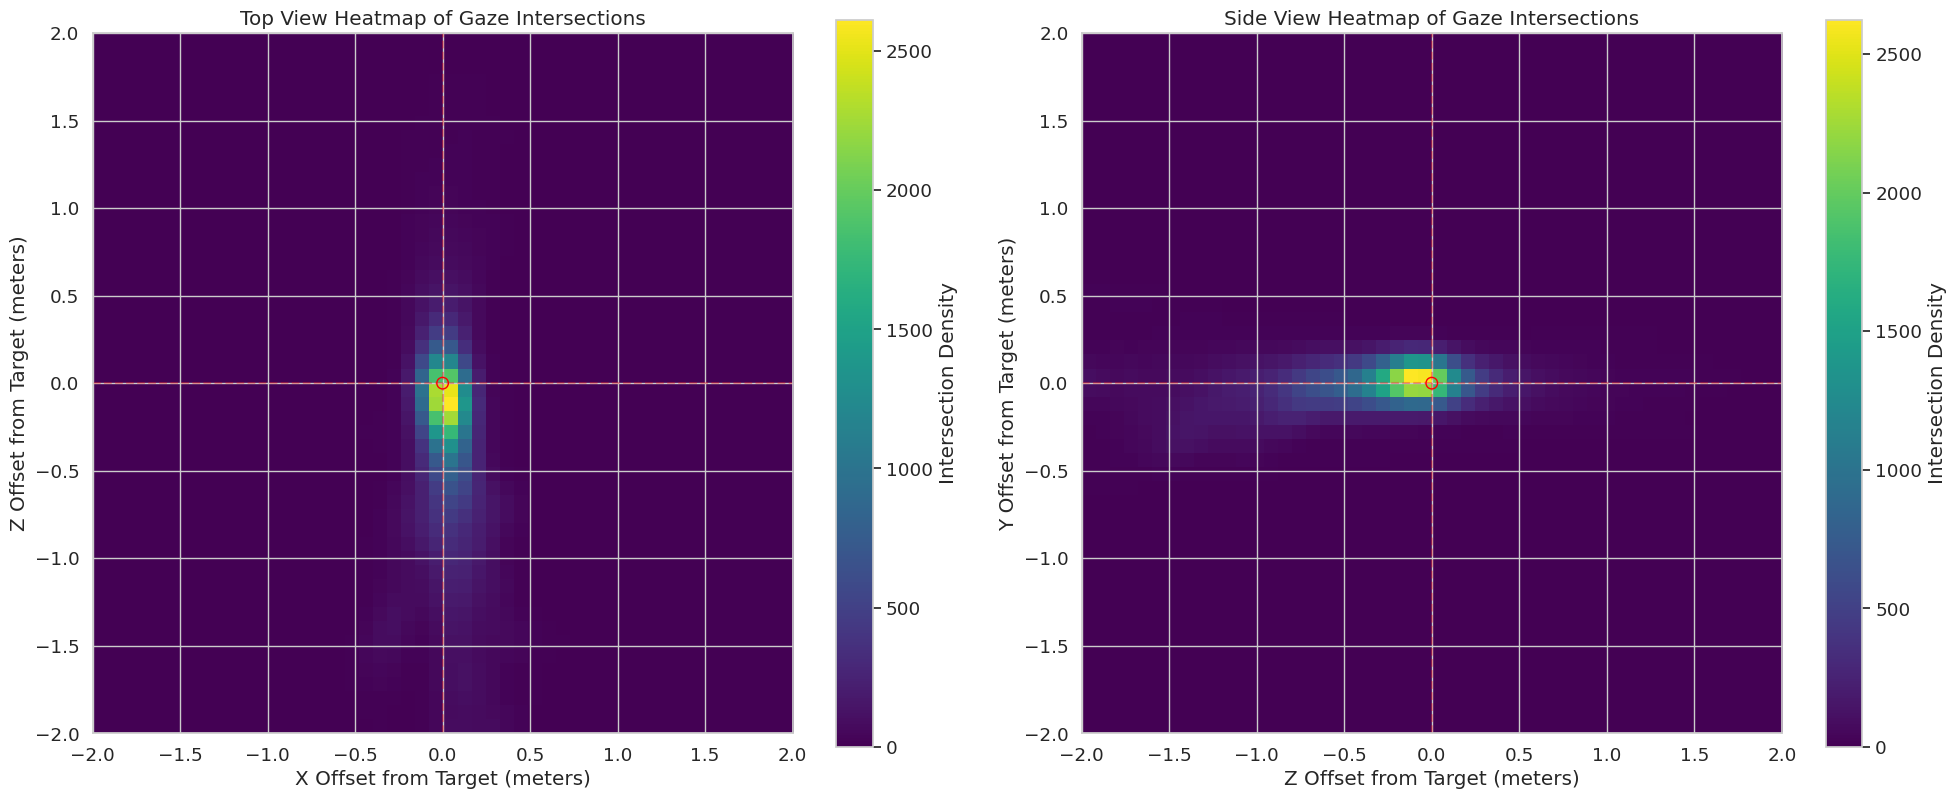

In [9]:
def create_gaze_heatmap(debug_df):
    """
    Create heatmaps showing the density of gaze intersections around targets
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Top View (X-Z plane)
    x = debug_df['relative_gaze_x']
    z = debug_df['relative_gaze_z']

    # Create 2D histogram for top view
    heatmap1, xedges1, yedges1 = np.histogram2d(
        x, z,
        bins=50,
        range=[[-2, 2], [-2, 2]]  # Adjust range as needed
    )
    # Smooth the heatmap
    heatmap1 = gaussian_filter(heatmap1, sigma=1)

    # Plot top view heatmap
    im1 = ax1.imshow(heatmap1.T,
                     extent=[-2, 2, -2, 2],
                     origin='lower',
                     cmap='viridis')

    # Add target circle
    target_circle1 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False)
    ax1.add_patch(target_circle1)

    ax1.set_title('Top View Heatmap of Gaze Intersections')
    ax1.set_xlabel('X Offset from Target (meters)')
    ax1.set_ylabel('Z Offset from Target (meters)')
    ax1.grid(True)

    # Side View (Y-Z plane)
    y = debug_df['relative_gaze_y']

    # Create 2D histogram for side view
    heatmap2, xedges2, yedges2 = np.histogram2d(
        z, y,
        bins=50,
        range=[[-2, 2], [-2, 2]]  # Adjust range as needed
    )
    # Smooth the heatmap
    heatmap2 = gaussian_filter(heatmap2, sigma=1)

    # Plot side view heatmap
    im2 = ax2.imshow(heatmap2.T,
                     extent=[-2, 2, -2, 2],
                     origin='lower',
                     cmap='viridis')

    # Add target circle
    target_circle2 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False)
    ax2.add_patch(target_circle2)

    ax2.set_title('Side View Heatmap of Gaze Intersections')
    ax2.set_xlabel('Z Offset from Target (meters)')
    ax2.set_ylabel('Y Offset from Target (meters)')
    ax2.grid(True)

    # Add colorbars
    plt.colorbar(im1, ax=ax1, label='Intersection Density')
    plt.colorbar(im2, ax=ax2, label='Intersection Density')

    # Add crosshairs
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Calculate density statistics
    density_stats = {
        'peak_density_top': np.max(heatmap1),
        'peak_density_side': np.max(heatmap2),
        'total_intersections': len(debug_df),
        'intersections_within_1m': len(debug_df[
            (debug_df['relative_gaze_x']**2 +
             debug_df['relative_gaze_y']**2 +
             debug_df['relative_gaze_z']**2) <= 1
        ])
    }

    return density_stats

# Run the analysis
density_stats = create_gaze_heatmap(debug_df)

print("\nGaze Intersection Density Statistics:")
for key, value in density_stats.items():
    print(f"{key}: {value}")

# 5. Micro-Scale Gaze Analysis: Defining Precise Activation Zones

This analysis provides a detailed examination of gaze intersection patterns within ±0.5m of the target, helping define optimal activation zone parameters for gaze-based interactions.

## Intersection Statistics by Radius:
- 100mm zone: 17,340 intersections (18.2%)
- 200mm zone: 29,759 intersections (31.2%)
- 300mm zone: 38,929 intersections (40.8%)
- 400mm zone: 45,275 intersections (47.5%)
- 500mm zone: 50,204 intersections (52.6%)

## Visualization Features:
1. High-Resolution Heatmaps:
   * 100 bins for increased detail
   * ±0.5m focused view
   * Reference circles at 100mm intervals

2. Dual-View Analysis:
   * Top View (X-Z plane): Shows horizontal spread patterns
   * Side View (Y-Z plane): Shows vertical distribution
   * Concentric reference circles for distance measurement

## Key Insights:
- Strong central concentration within 200mm
- Significant jump in intersections from 100mm to 200mm zone
- Diminishing returns beyond 300mm
- Asymmetric distribution between horizontal and vertical planes

## Design Recommendations:
1. Primary Activation Zone:
   * Core zone: 100mm (captures 18.2% of precise interactions)
   * Extended zone: 200mm (captures 31.2% of interactions)

2. Progressive Activation:
   * Consider tiered activation zones
   * Weight interaction confidence by proximity
   * Balance precision vs. accessibility


Detailed Intersection Statistics:
within_100mm: 17340 intersections (18.2%)
within_200mm: 29759 intersections (31.2%)
within_300mm: 38929 intersections (40.8%)
within_400mm: 45275 intersections (47.5%)
within_500mm: 50204 intersections (52.6%)


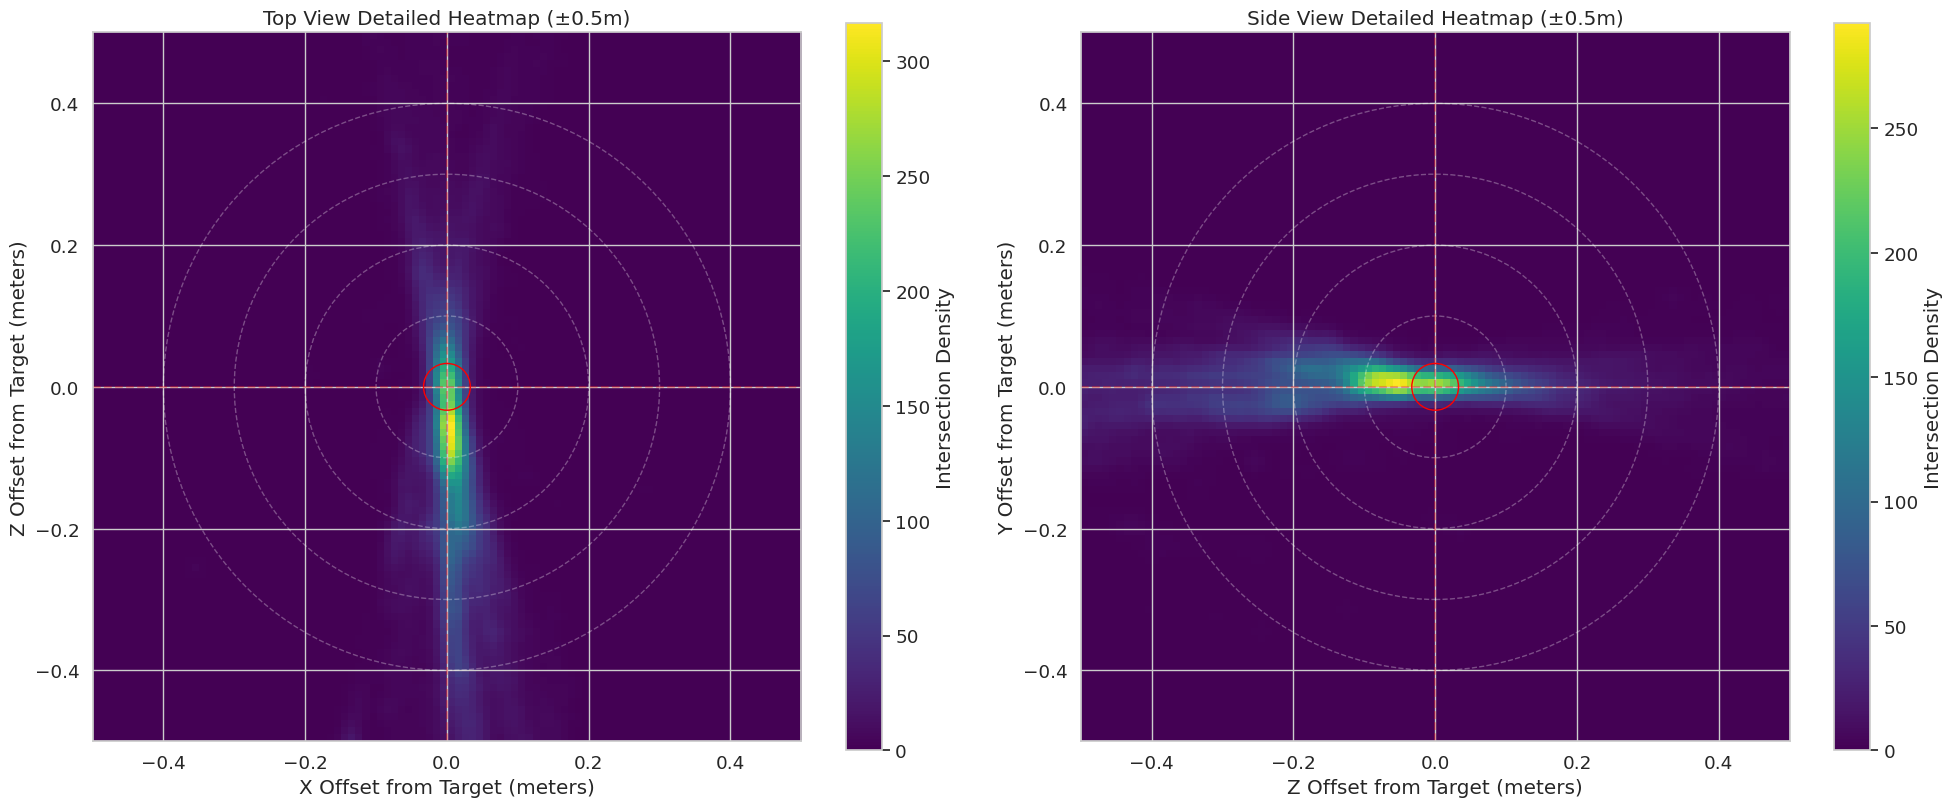

In [10]:
def create_detailed_gaze_heatmap(debug_df):
    """
    Create detailed heatmaps with closer zoom and more granular analysis
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Set zoom range (in meters)
    zoom_range = 0.5
    bins = 100  # Increased resolution

    # Top View (X-Z plane)
    x = debug_df['relative_gaze_x']
    z = debug_df['relative_gaze_z']

    # Create 2D histogram for top view
    heatmap1, xedges1, yedges1 = np.histogram2d(
        x, z,
        bins=bins,
        range=[[-zoom_range, zoom_range], [-zoom_range, zoom_range]]
    )
    heatmap1 = gaussian_filter(heatmap1, sigma=1)

    # Plot top view heatmap
    im1 = ax1.imshow(heatmap1.T,
                     extent=[-zoom_range, zoom_range, -zoom_range, zoom_range],
                     origin='lower',
                     cmap='viridis')

    # Add reference circles (every 10cm)
    for r in np.arange(0.1, zoom_range, 0.1):
        circle1 = plt.Circle((0, 0), r, color='white', fill=False, alpha=0.3, linestyle='--')
        ax1.add_patch(circle1)

    # Add target circle
    target_circle1 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False)
    ax1.add_patch(target_circle1)

    ax1.set_title('Top View Detailed Heatmap (±0.5m)')
    ax1.set_xlabel('X Offset from Target (meters)')
    ax1.set_ylabel('Z Offset from Target (meters)')
    ax1.grid(True)

    # Side View (Y-Z plane)
    y = debug_df['relative_gaze_y']

    # Create 2D histogram for side view
    heatmap2, xedges2, yedges2 = np.histogram2d(
        z, y,
        bins=bins,
        range=[[-zoom_range, zoom_range], [-zoom_range, zoom_range]]
    )
    heatmap2 = gaussian_filter(heatmap2, sigma=1)

    # Plot side view heatmap
    im2 = ax2.imshow(heatmap2.T,
                     extent=[-zoom_range, zoom_range, -zoom_range, zoom_range],
                     origin='lower',
                     cmap='viridis')

    # Add reference circles
    for r in np.arange(0.1, zoom_range, 0.1):
        circle2 = plt.Circle((0, 0), r, color='white', fill=False, alpha=0.3, linestyle='--')
        ax2.add_patch(circle2)

    # Add target circle
    target_circle2 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False)
    ax2.add_patch(target_circle2)

    ax2.set_title('Side View Detailed Heatmap (±0.5m)')
    ax2.set_xlabel('Z Offset from Target (meters)')
    ax2.set_ylabel('Y Offset from Target (meters)')
    ax2.grid(True)

    # Add colorbars
    plt.colorbar(im1, ax=ax1, label='Intersection Density')
    plt.colorbar(im2, ax=ax2, label='Intersection Density')

    # Add crosshairs
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Calculate detailed statistics
    radius_stats = {}
    for r in [0.1, 0.2, 0.3, 0.4, 0.5]:
        intersections = len(debug_df[
            (debug_df['relative_gaze_x']**2 +
             debug_df['relative_gaze_y']**2 +
             debug_df['relative_gaze_z']**2) <= r**2
        ])
        radius_stats[f'within_{int(r*1000)}mm'] = intersections

    return radius_stats

# Run the detailed analysis
radius_stats = create_detailed_gaze_heatmap(debug_df)

print("\nDetailed Intersection Statistics:")
for radius, count in radius_stats.items():
    percentage = (count / len(debug_df)) * 100
    print(f"{radius}: {count} intersections ({percentage:.1f}%)")

# 6. Ultra-Precise Gaze Analysis: Fine-Tuning the Activation Zone

This analysis provides an ultra-detailed examination of gaze behavior within ±150mm of the target, revealing precise patterns for optimizing activation zones.

## Micro-Range Statistics:
Progressive Capture Rates:
- 25mm zone: 3,160 intersections (3.3%)
- 50mm zone: 8,122 intersections (8.5%)
- 75mm zone: 12,819 intersections (13.4%)
- 100mm zone: 17,340 intersections (18.2%)
- 125mm zone: 21,128 intersections (22.2%)
- 150mm zone: 24,150 intersections (25.3%)

## Quadrant Analysis (150mm zone):
- Bottom Right: 9,508 intersections (40.0%)
- Bottom Left: 5,771 intersections (24.3%)
- Top Left: 4,569 intersections (19.2%)
- Top Right: 3,896 intersections (16.4%)

## Visualization Features:
1. Ultra-High Resolution:
   * 150 bins within ±150mm range
   * 25mm reference circles
   * Precise density mapping

2. Key Observations:
   * Strong bottom-right bias in intersection distribution
   * Clear vertical asymmetry in gaze patterns
   * Distinct clustering patterns at different ranges

## Design Recommendations:
1. Primary Activation Zone:
   * Core precision zone: 50mm (8.5% capture)
   * Standard zone: 100mm (18.2% capture)
   * Extended zone: 150mm (25.3% capture)

2. Asymmetric Considerations:
   * Account for bottom-right bias
   * Consider weighted activation zones
   * Adjust for vertical offset patterns


Micro-Range Intersection Statistics:
within_25mm: 3160 intersections (3.3%)
within_50mm: 8122 intersections (8.5%)
within_75mm: 12819 intersections (13.4%)
within_100mm: 17340 intersections (18.2%)
within_125mm: 21128 intersections (22.2%)
within_150mm: 24150 intersections (25.3%)

Quadrant Distribution (within 150mm):
top_right: 3896 intersections (16.4%)
top_left: 4569 intersections (19.2%)
bottom_right: 9508 intersections (40.0%)
bottom_left: 5771 intersections (24.3%)


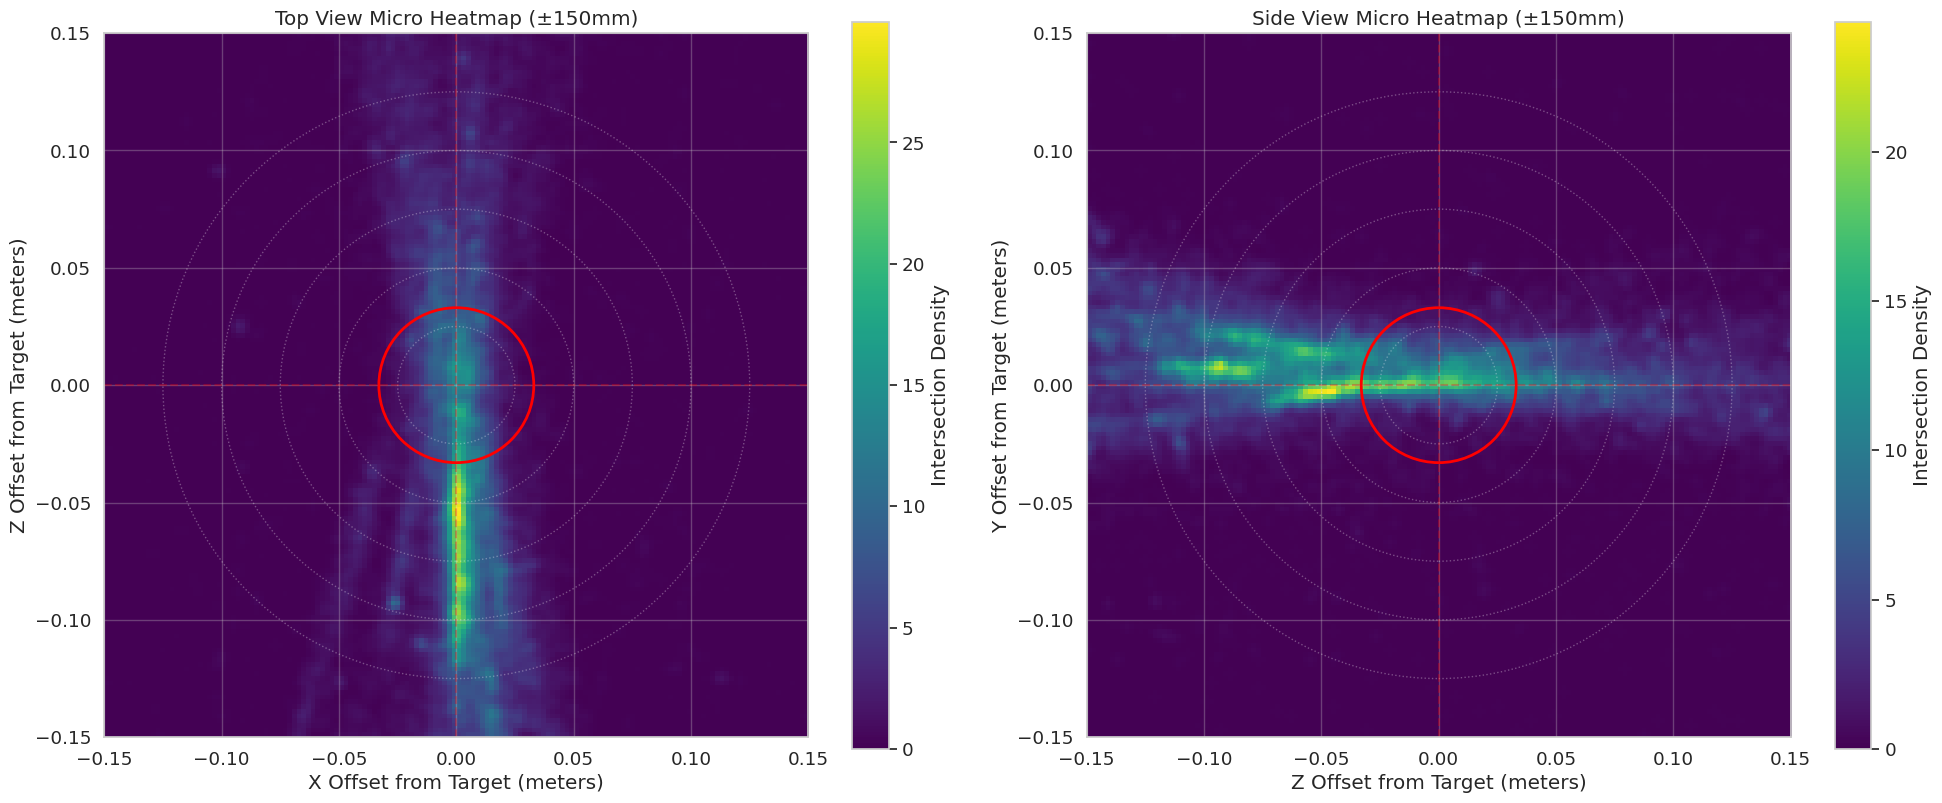

In [11]:
def create_micro_gaze_heatmap(debug_df):
    """
    Create highly detailed heatmaps focusing on very close range (±150mm)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Set zoom range (in meters)
    zoom_range = 0.15  # 150mm
    bins = 150  # Even higher resolution

    # Top View (X-Z plane)
    x = debug_df['relative_gaze_x']
    z = debug_df['relative_gaze_z']

    # Create 2D histogram for top view
    heatmap1, xedges1, yedges1 = np.histogram2d(
        x, z,
        bins=bins,
        range=[[-zoom_range, zoom_range], [-zoom_range, zoom_range]]
    )
    heatmap1 = gaussian_filter(heatmap1, sigma=1)

    # Plot top view heatmap
    im1 = ax1.imshow(heatmap1.T,
                     extent=[-zoom_range, zoom_range, -zoom_range, zoom_range],
                     origin='lower',
                     cmap='viridis')

    # Add reference circles (every 25mm)
    for r in np.arange(0.025, zoom_range, 0.025):
        circle1 = plt.Circle((0, 0), r, color='white', fill=False, alpha=0.3, linestyle=':')
        ax1.add_patch(circle1)

    # Add target circle
    target_circle1 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False, linewidth=2)
    ax1.add_patch(target_circle1)

    ax1.set_title('Top View Micro Heatmap (±150mm)')
    ax1.set_xlabel('X Offset from Target (meters)')
    ax1.set_ylabel('Z Offset from Target (meters)')
    ax1.grid(True, alpha=0.3)

    # Side View (Y-Z plane)
    y = debug_df['relative_gaze_y']

    # Create 2D histogram for side view
    heatmap2, xedges2, yedges2 = np.histogram2d(
        z, y,
        bins=bins,
        range=[[-zoom_range, zoom_range], [-zoom_range, zoom_range]]
    )
    heatmap2 = gaussian_filter(heatmap2, sigma=1)

    # Plot side view heatmap
    im2 = ax2.imshow(heatmap2.T,
                     extent=[-zoom_range, zoom_range, -zoom_range, zoom_range],
                     origin='lower',
                     cmap='viridis')

    # Add reference circles
    for r in np.arange(0.025, zoom_range, 0.025):
        circle2 = plt.Circle((0, 0), r, color='white', fill=False, alpha=0.3, linestyle=':')
        ax2.add_patch(circle2)

    # Add target circle
    target_circle2 = plt.Circle((0, 0), debug_df['target_diameter'].iloc[0]/2,
                              color='red', fill=False, linewidth=2)
    ax2.add_patch(target_circle2)

    ax2.set_title('Side View Micro Heatmap (±150mm)')
    ax2.set_xlabel('Z Offset from Target (meters)')
    ax2.set_ylabel('Y Offset from Target (meters)')
    ax2.grid(True, alpha=0.3)

    # Add colorbars
    plt.colorbar(im1, ax=ax1, label='Intersection Density')
    plt.colorbar(im2, ax=ax2, label='Intersection Density')

    # Add crosshairs
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Calculate very detailed statistics
    micro_stats = {}
    for r in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]:
        intersections = len(debug_df[
            (debug_df['relative_gaze_x']**2 +
             debug_df['relative_gaze_y']**2 +
             debug_df['relative_gaze_z']**2) <= r**2
        ])
        micro_stats[f'within_{int(r*1000)}mm'] = intersections

    # Calculate density in each quadrant (top view)
    quadrant_stats = {
        'top_right': len(debug_df[(x > 0) & (z > 0) & (x**2 + z**2 <= zoom_range**2)]),
        'top_left': len(debug_df[(x < 0) & (z > 0) & (x**2 + z**2 <= zoom_range**2)]),
        'bottom_right': len(debug_df[(x > 0) & (z < 0) & (x**2 + z**2 <= zoom_range**2)]),
        'bottom_left': len(debug_df[(x < 0) & (z < 0) & (x**2 + z**2 <= zoom_range**2)])
    }

    return micro_stats, quadrant_stats

# Run the micro analysis
micro_stats, quadrant_stats = create_micro_gaze_heatmap(debug_df)

print("\nMicro-Range Intersection Statistics:")
for radius, count in micro_stats.items():
    percentage = (count / len(debug_df)) * 100
    print(f"{radius}: {count} intersections ({percentage:.1f}%)")

print("\nQuadrant Distribution (within 150mm):")
total_in_range = sum(quadrant_stats.values())
for quadrant, count in quadrant_stats.items():
    percentage = (count / total_in_range) * 100 if total_in_range > 0 else 0
    print(f"{quadrant}: {count} intersections ({percentage:.1f}%)")

# 7. Dwell Time Analysis: Understanding Gaze Stability Patterns

This analysis examines how long users maintain their gaze within various proximity zones of the target, crucial for determining optimal dwell-time thresholds for activation.

## Dwell Statistics by Proximity Zone:

### 50mm Zone (Precise):
- Total dwells: 3,313
- Mean dwell: 0.041s
- Median dwell: 0.017s
- Max dwell: 2.155s
- \>0.5s: 0.6%
- \>1.0s: 0.1%

### 100mm Zone (Standard):
- Total dwells: 4,706
- Mean dwell: 0.058s
- Median dwell: 0.018s
- Max dwell: 9.218s
- \>0.5s: 1.3%
- \>1.0s: 0.4%

### 150mm Zone (Extended):
- Total dwells: 5,081
- Mean dwell: 0.070s
- Median dwell: 0.020s
- Max dwell: 15.244s
- \>0.5s: 1.4%
- \>1.0s: 0.5%

## Key Insights:
1. Dwell Duration Patterns:
   * Most dwells are very brief (<50ms)
   * Longer dwells become exponentially rarer
   * Larger zones enable longer maximum dwells

2. Zone Size Impact:
   * Larger zones capture more dwells
   * Modest increase in sustained dwells
   * Diminishing returns beyond 150mm

## Design Recommendations:
1. Dwell Thresholds:
   * Consider 0.5s minimum for intentional activation
   * Balance between accessibility (1.3-1.4% success rate) and false positives
   * Implement progressive feedback during dwell

2. Zone Configuration:
   * 100mm zone provides good balance
   * Consider adaptive thresholds based on target size
   * Account for natural gaze instability


Dwell Statistics for 50mm threshold:
Total dwell periods: 3313
Mean dwell time: 0.041 seconds
Median dwell time: 0.017 seconds
Maximum dwell time: 2.155 seconds
Percentage of dwells > 0.5s: 0.6%
Percentage of dwells > 1.0s: 0.1%
Percentage of dwells > 1.5s: 0.1%

Dwell Statistics for 75mm threshold:
Total dwell periods: 4150
Mean dwell time: 0.050 seconds
Median dwell time: 0.018 seconds
Maximum dwell time: 3.891 seconds
Percentage of dwells > 0.5s: 1.0%
Percentage of dwells > 1.0s: 0.4%
Percentage of dwells > 1.5s: 0.2%

Dwell Statistics for 100mm threshold:
Total dwell periods: 4706
Mean dwell time: 0.058 seconds
Median dwell time: 0.018 seconds
Maximum dwell time: 9.218 seconds
Percentage of dwells > 0.5s: 1.3%
Percentage of dwells > 1.0s: 0.4%
Percentage of dwells > 1.5s: 0.2%

Dwell Statistics for 125mm threshold:
Total dwell periods: 4871
Mean dwell time: 0.068 seconds
Median dwell time: 0.018 seconds
Maximum dwell time: 9.234 seconds
Percentage of dwells > 0.5s: 1.4%
Percentage

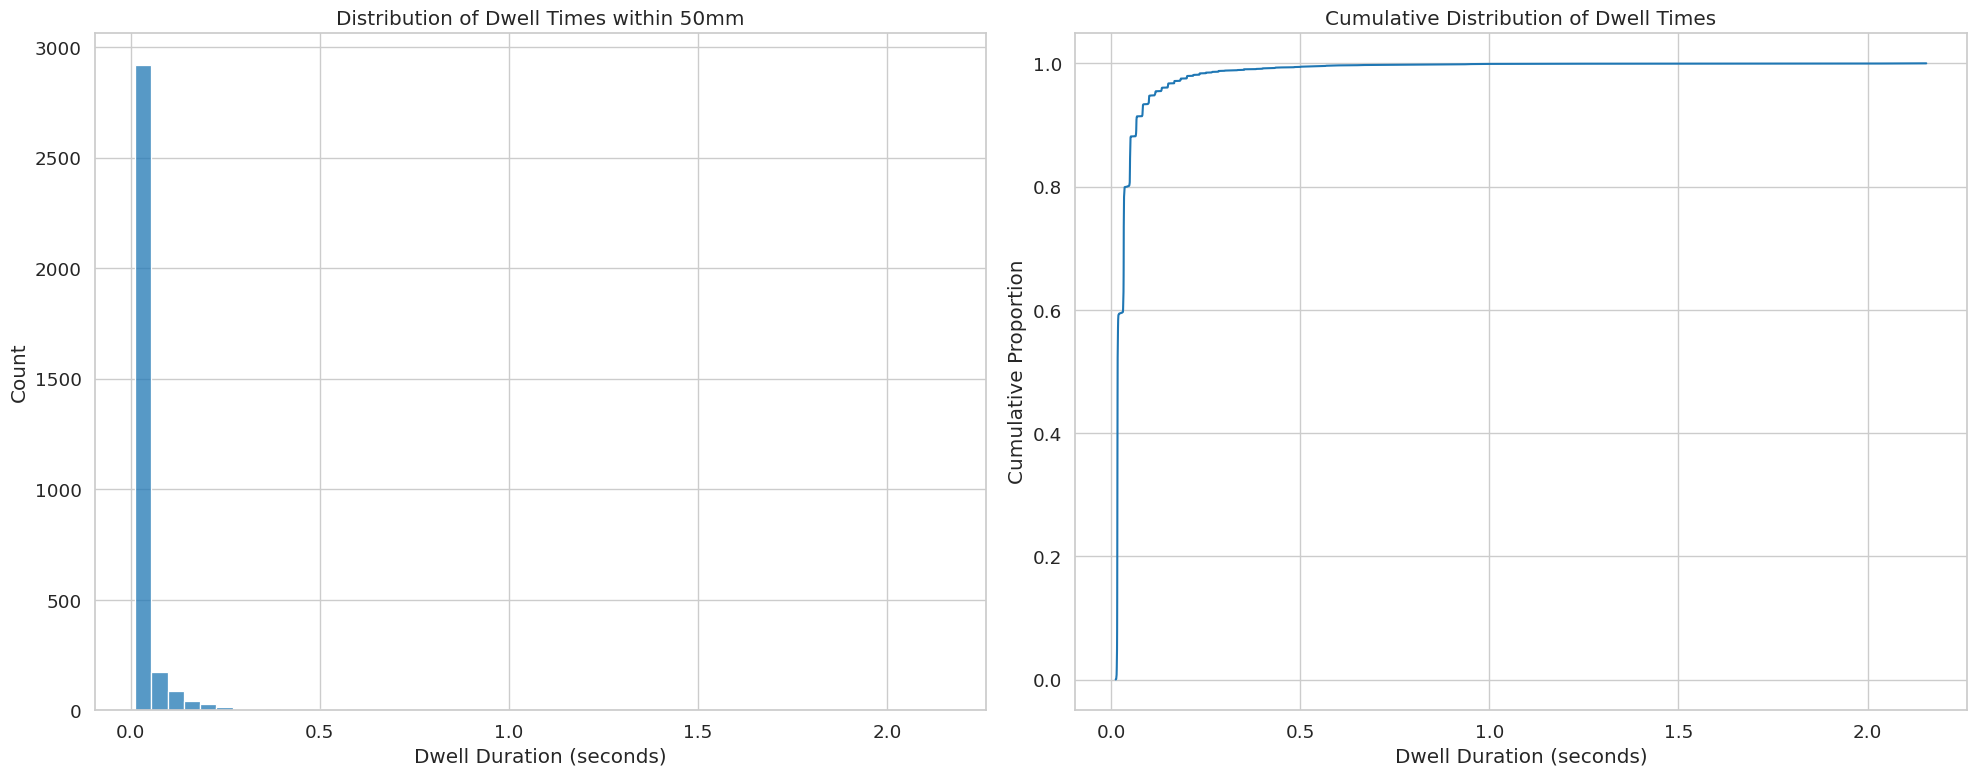

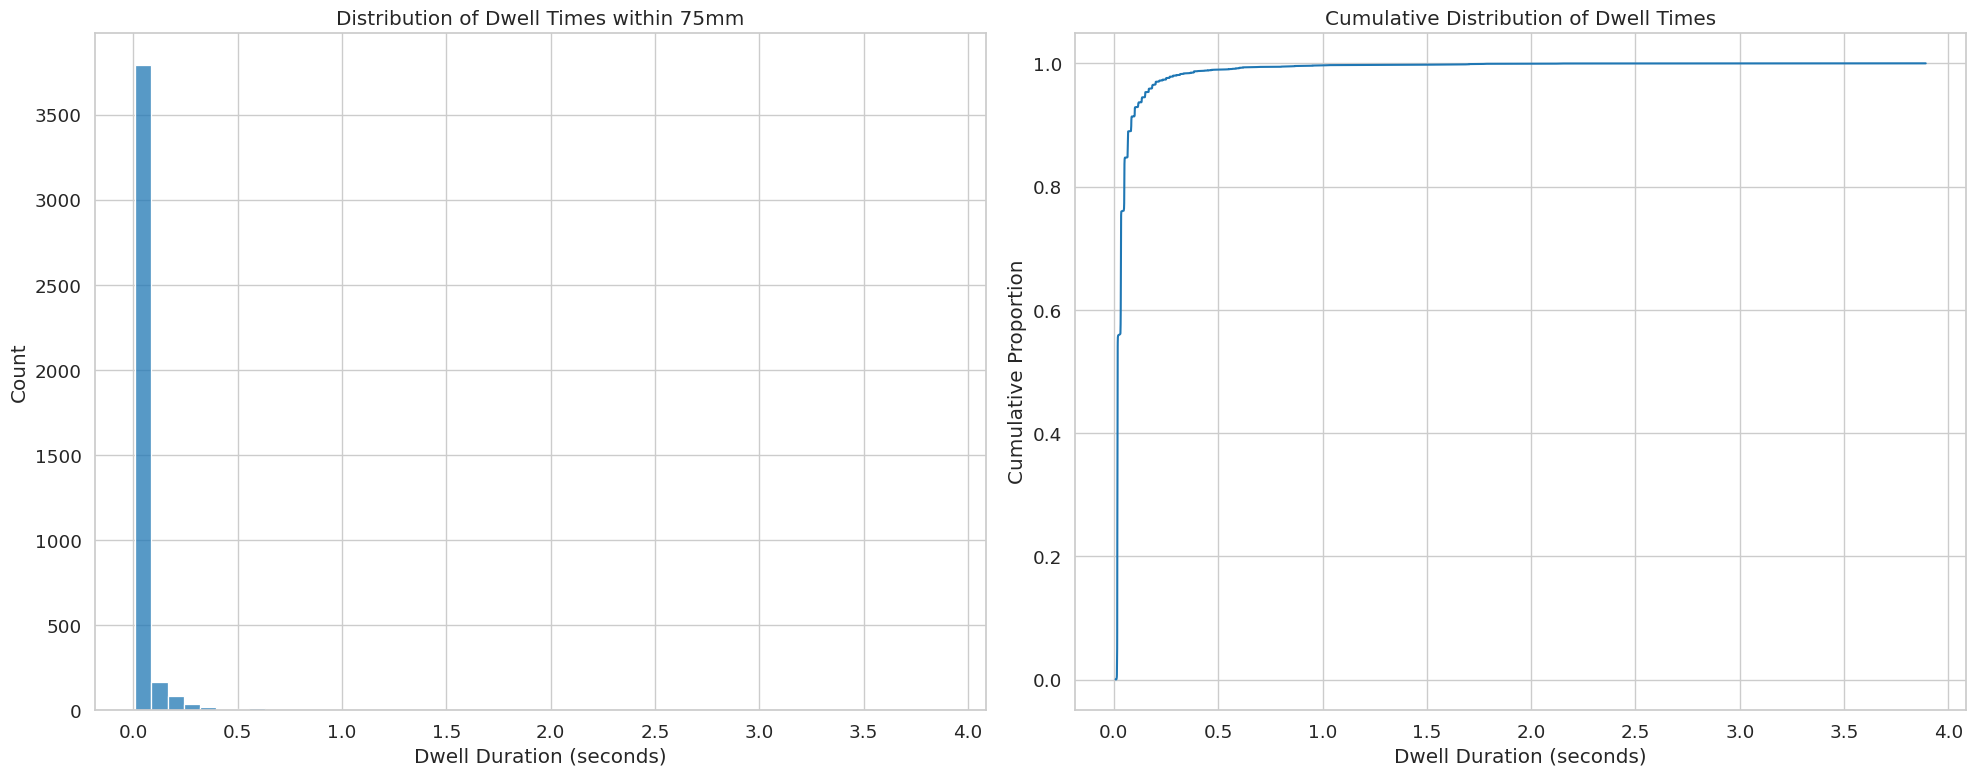

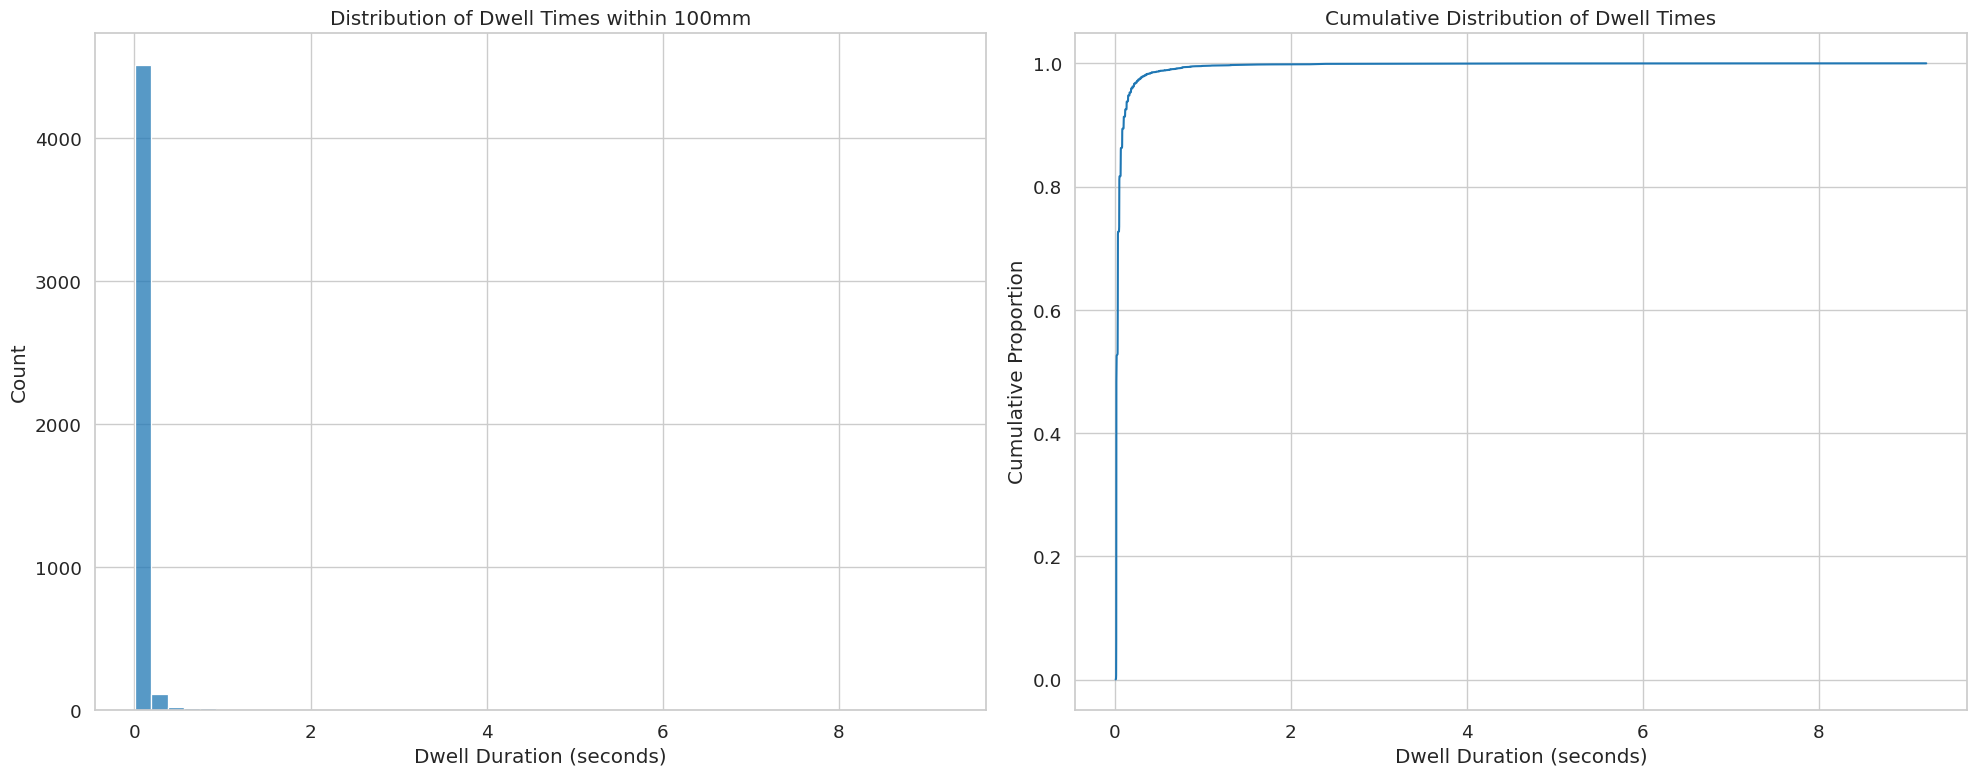

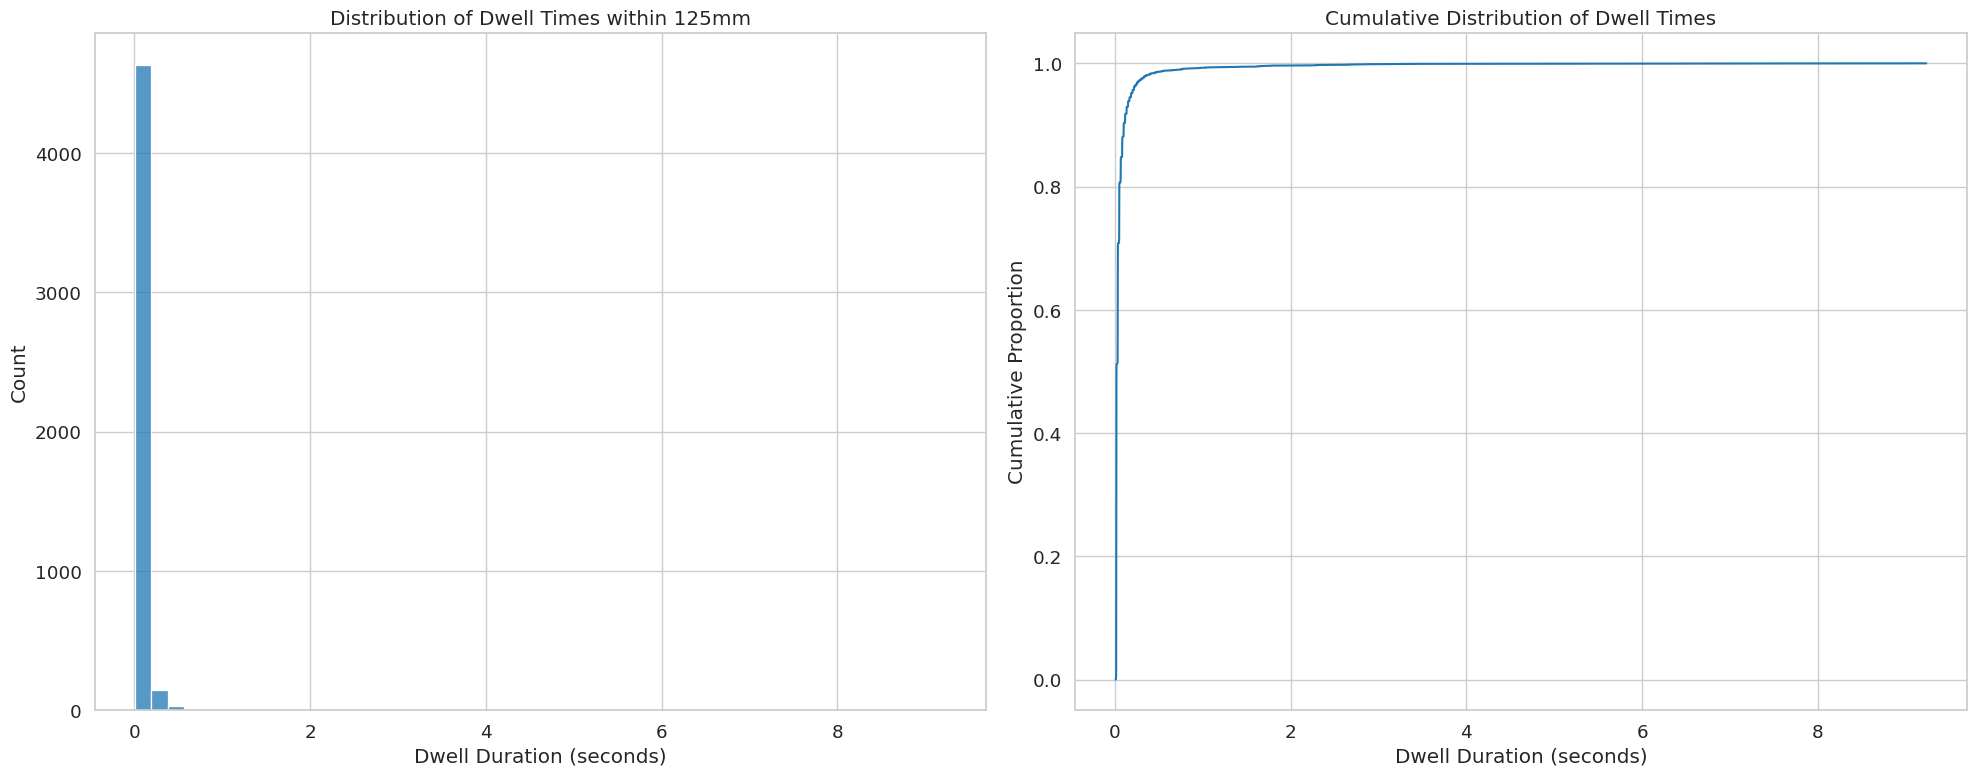

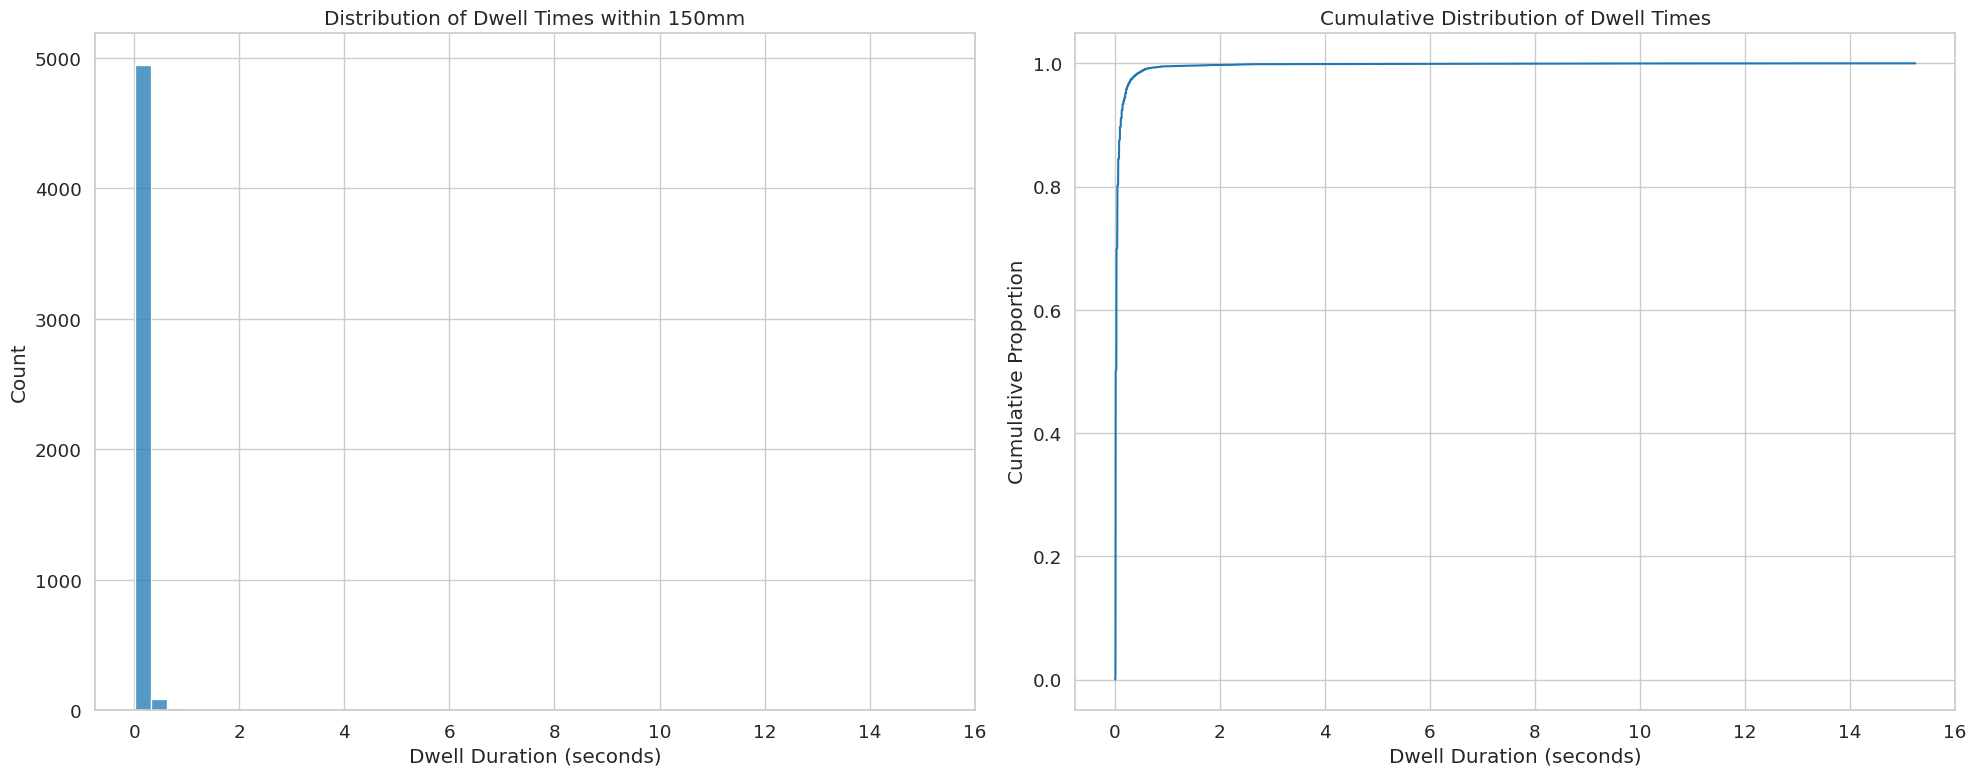

In [12]:
def analyze_gaze_dwell_times(debug_df, proximity_threshold=0.1):  # 100mm default
    """
    Analyze how long gaze intersections remain within specified proximity of target
    """
    # Sort by scene and time
    debug_df = debug_df.sort_values(['scene_name', 'time_from_start'])

    # Calculate 3D distance for each point
    debug_df['distance_3d'] = np.sqrt(
        debug_df['relative_gaze_x']**2 +
        debug_df['relative_gaze_y']**2 +
        debug_df['relative_gaze_z']**2
    )

    # Initialize variables for tracking dwell periods
    dwell_periods = []
    current_dwell_start = None

    # Analyze each scene separately
    for scene_name in debug_df['scene_name'].unique():
        scene_data = debug_df[debug_df['scene_name'] == scene_name].copy()

        # Reset for new scene
        current_dwell_start = None

        for idx, row in scene_data.iterrows():
            within_threshold = row['distance_3d'] <= proximity_threshold

            if within_threshold and current_dwell_start is None:
                # Start of new dwell period
                current_dwell_start = row['time_from_start']
            elif not within_threshold and current_dwell_start is not None:
                # End of dwell period
                dwell_duration = row['time_from_start'] - current_dwell_start
                dwell_periods.append(dwell_duration)
                current_dwell_start = None

    # Convert to numpy array for analysis
    dwell_periods = np.array(dwell_periods)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Distribution of dwell times
    sns.histplot(dwell_periods, bins=50, ax=ax1)
    ax1.set_title(f'Distribution of Dwell Times within {proximity_threshold*1000:.0f}mm')
    ax1.set_xlabel('Dwell Duration (seconds)')
    ax1.set_ylabel('Count')

    # Plot 2: Cumulative distribution
    sorted_dwells = np.sort(dwell_periods)
    cumulative = np.arange(1, len(sorted_dwells) + 1) / len(sorted_dwells)
    ax2.plot(sorted_dwells, cumulative)
    ax2.set_title('Cumulative Distribution of Dwell Times')
    ax2.set_xlabel('Dwell Duration (seconds)')
    ax2.set_ylabel('Cumulative Proportion')
    ax2.grid(True)

    plt.tight_layout()

    # Calculate statistics
    dwell_stats = {
        'total_dwell_periods': len(dwell_periods),
        'mean_dwell_time': np.mean(dwell_periods),
        'median_dwell_time': np.median(dwell_periods),
        'std_dwell_time': np.std(dwell_periods),
        'dwells_over_0.5s': np.sum(dwell_periods >= 0.5) / len(dwell_periods) * 100,
        'dwells_over_1.0s': np.sum(dwell_periods >= 1.0) / len(dwell_periods) * 100,
        'dwells_over_1.5s': np.sum(dwell_periods >= 1.5) / len(dwell_periods) * 100,
        'max_dwell_time': np.max(dwell_periods)
    }

    return dwell_stats, dwell_periods

# Analyze dwell times for different proximity thresholds
thresholds = [0.05, 0.075, 0.1, 0.125, 0.15]  # in meters
all_stats = {}

for threshold in thresholds:
    stats, periods = analyze_gaze_dwell_times(debug_df, threshold)
    all_stats[f'{int(threshold*1000)}mm'] = stats

# Print results
for threshold, stats in all_stats.items():
    print(f"\nDwell Statistics for {threshold} threshold:")
    print(f"Total dwell periods: {stats['total_dwell_periods']}")
    print(f"Mean dwell time: {stats['mean_dwell_time']:.3f} seconds")
    print(f"Median dwell time: {stats['median_dwell_time']:.3f} seconds")
    print(f"Maximum dwell time: {stats['max_dwell_time']:.3f} seconds")
    print(f"Percentage of dwells > 0.5s: {stats['dwells_over_0.5s']:.1f}%")
    print(f"Percentage of dwells > 1.0s: {stats['dwells_over_1.0s']:.1f}%")
    print(f"Percentage of dwells > 1.5s: {stats['dwells_over_1.5s']:.1f}%")

# 8. Comparative Dwell Analysis: Multi-Zone Temporal Patterns

This visualization combines dwell time distributions across different proximity thresholds (50mm-150mm), providing insights into how zone size affects gaze stability patterns.

## Visualization Components:

1. Distribution Plot (0-0.5s Focus):
   * Color-coded by zone size
   * Shows frequency of dwell durations
   * Focused on most common duration range
   * Reveals immediate differences between zones

2. Cumulative Distribution (Log Scale):
   * Shows complete dwell time distribution
   * Logarithmic scale highlights tail behavior
   * 0.5s threshold reference line
   * Enables direct zone comparison

## Key Observations:

1. Distribution Patterns:
   * All zones show similar basic shape
   * Larger zones capture more dwells
   * Peak frequency remains in sub-100ms range
   * Long-tail distribution for all zones

2. Zone Size Effects:
   * Minimal impact on short dwell distribution
   * Larger zones enable more sustained dwells
   * Progressive increase in maximum dwell times
   * Similar cumulative patterns across zones

## Design Implications:
1. Zone Selection:
   * Choose based on intended interaction time
   * Consider trade-off between accessibility and precision
   * Account for natural gaze behavior patterns

2. Threshold Setting:
   * 0.5s marks significant cumulative percentage
   * Consider multi-stage activation for different dwell times
   * Balance between intentional and accidental activation

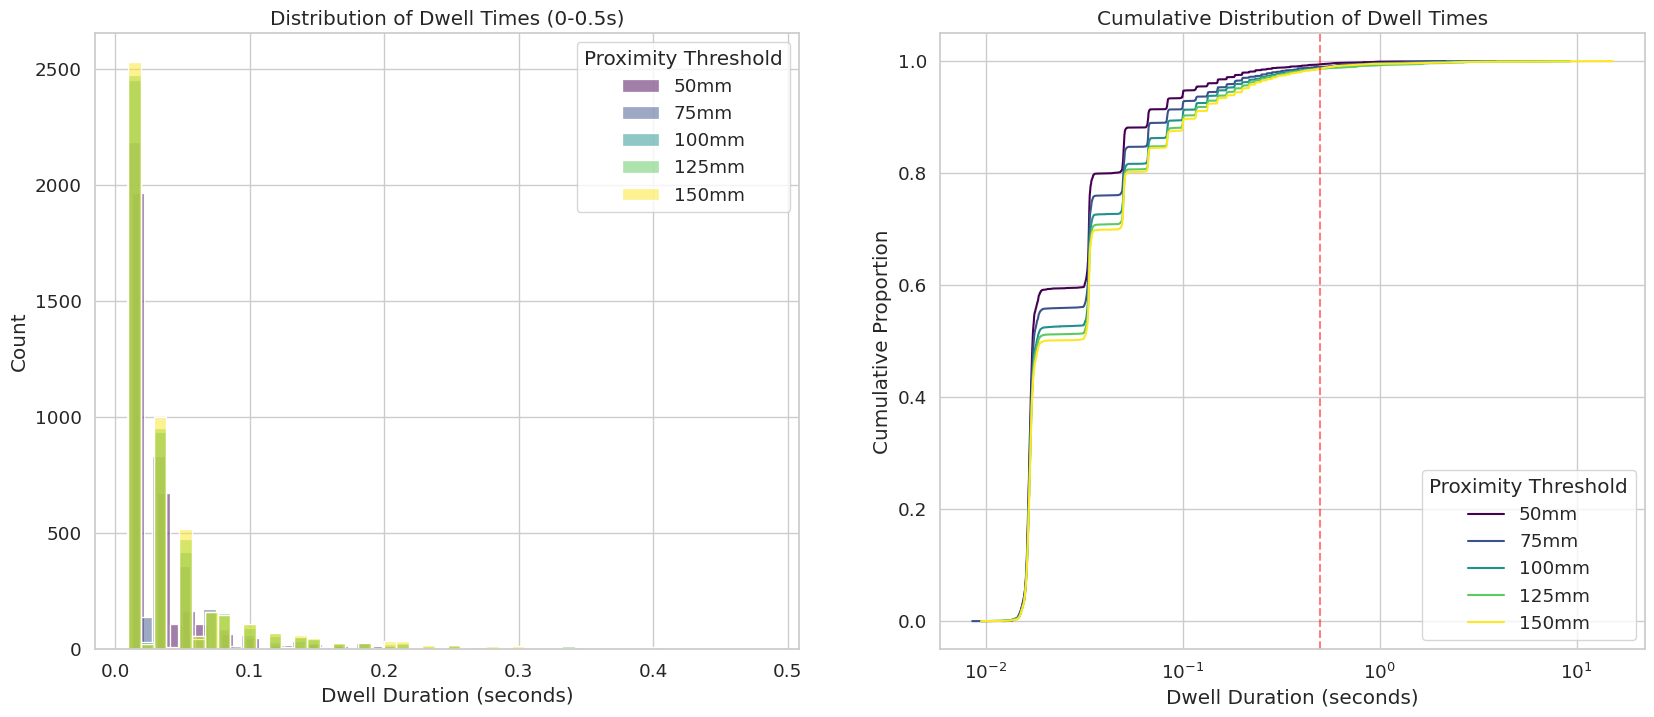

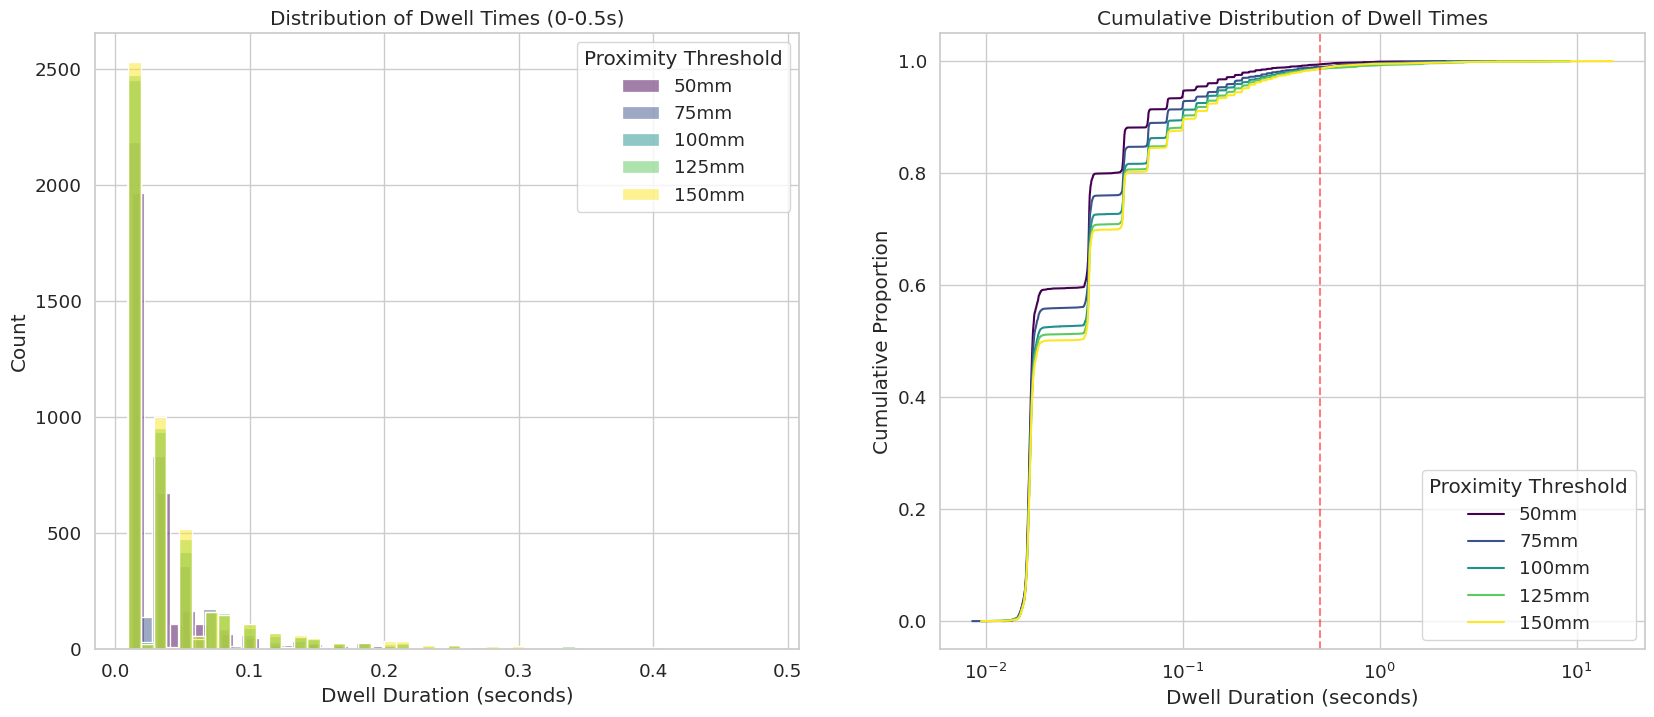

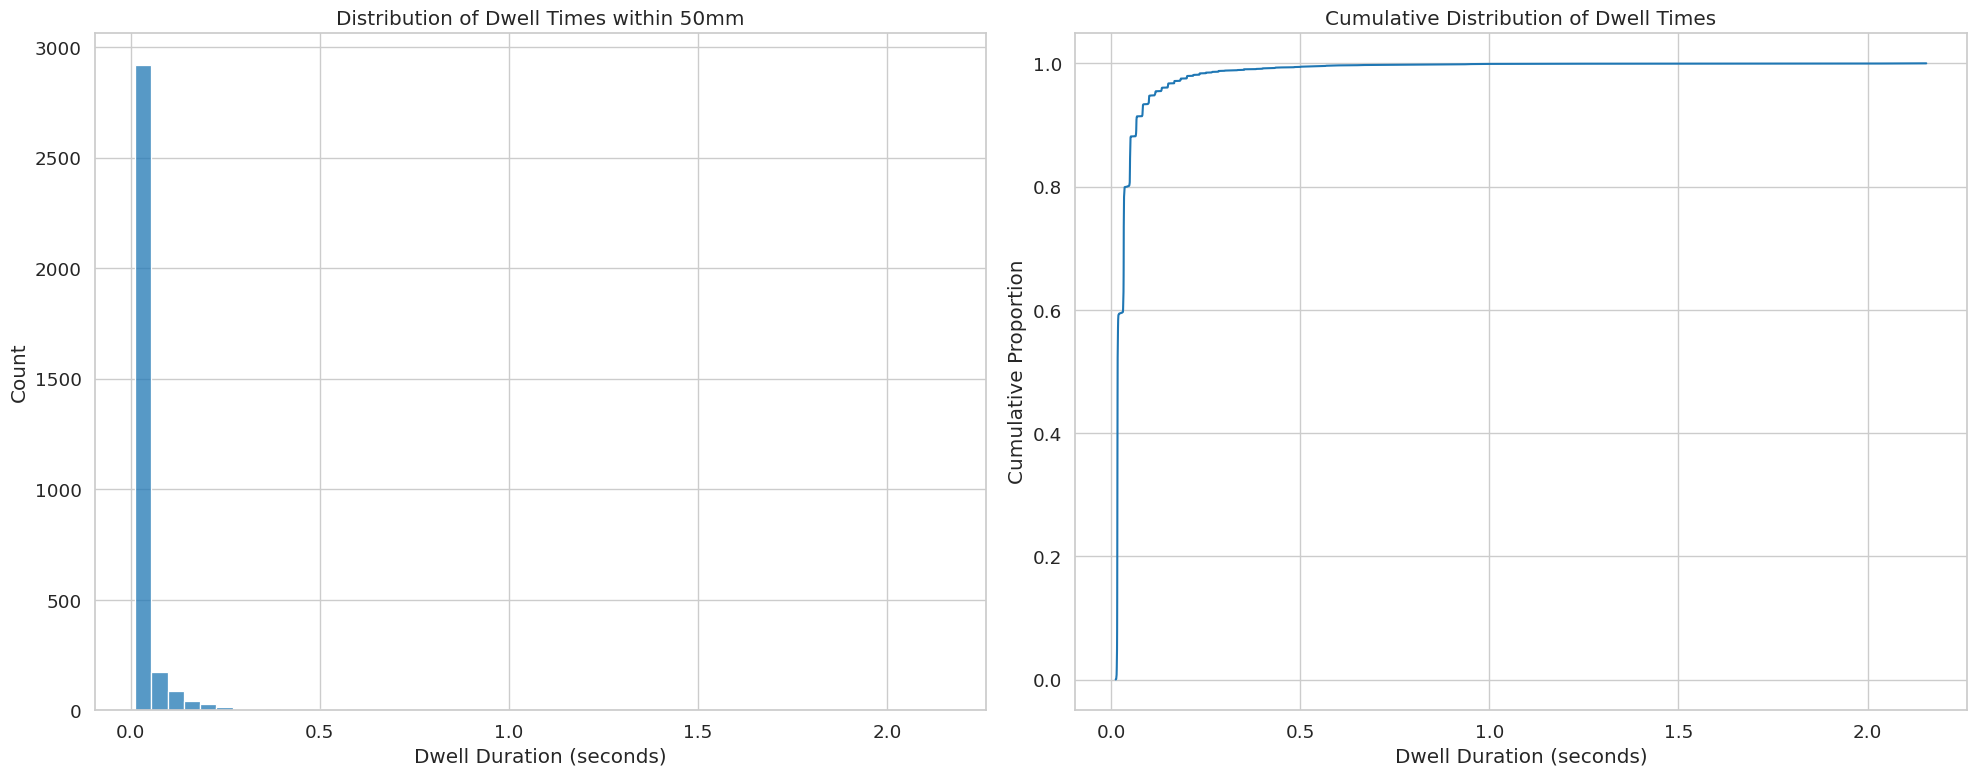

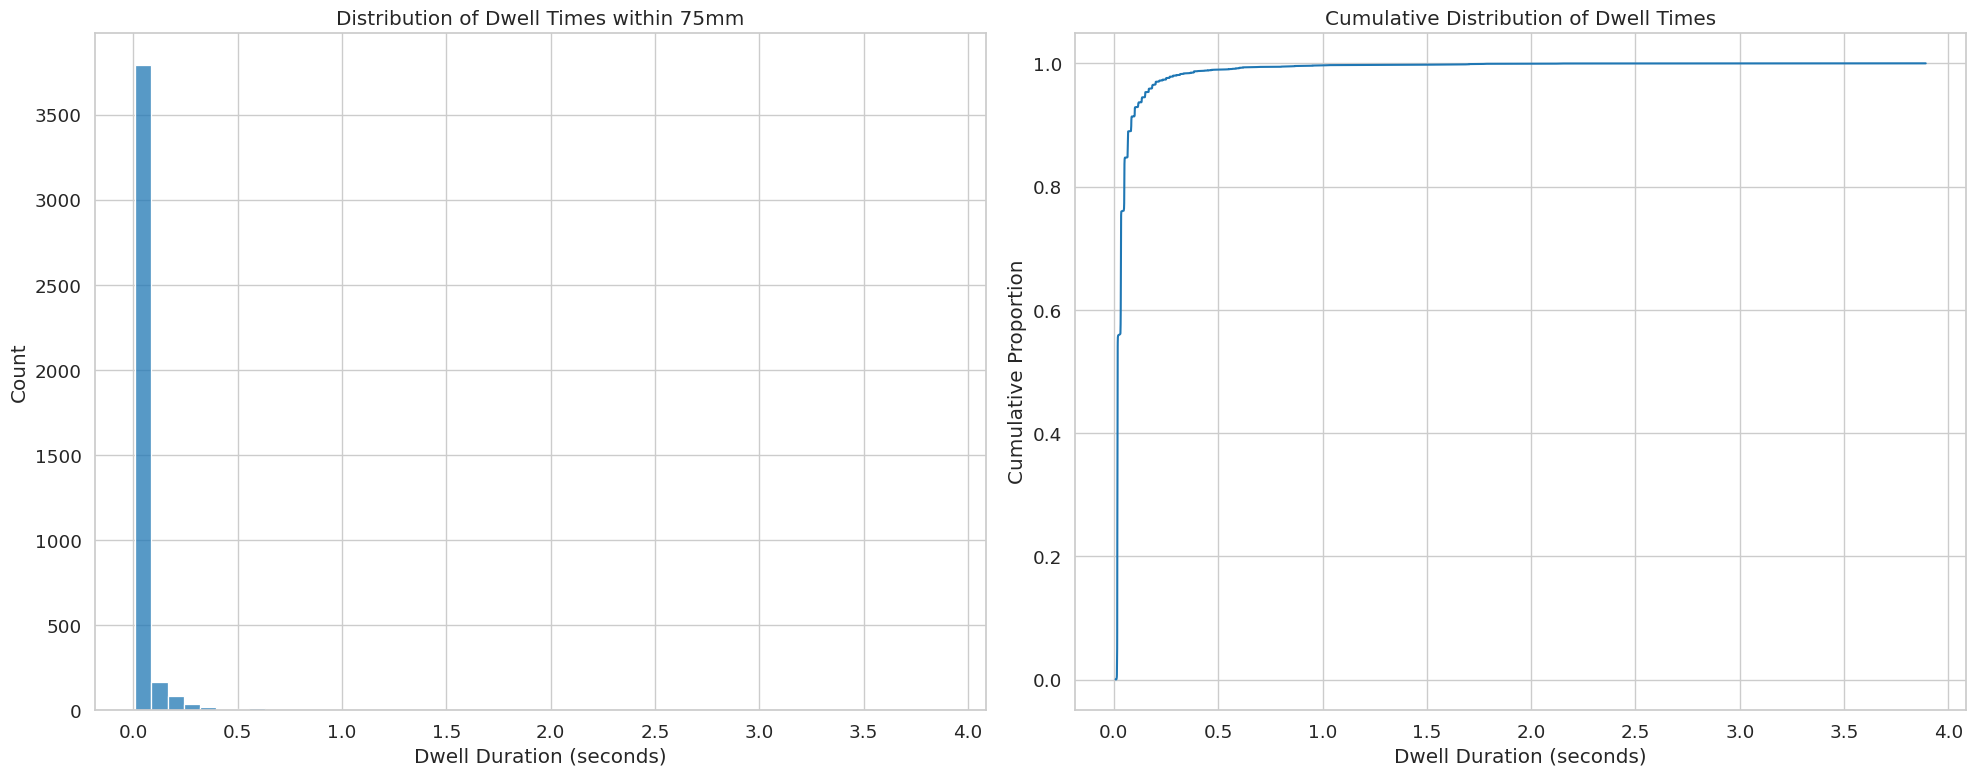

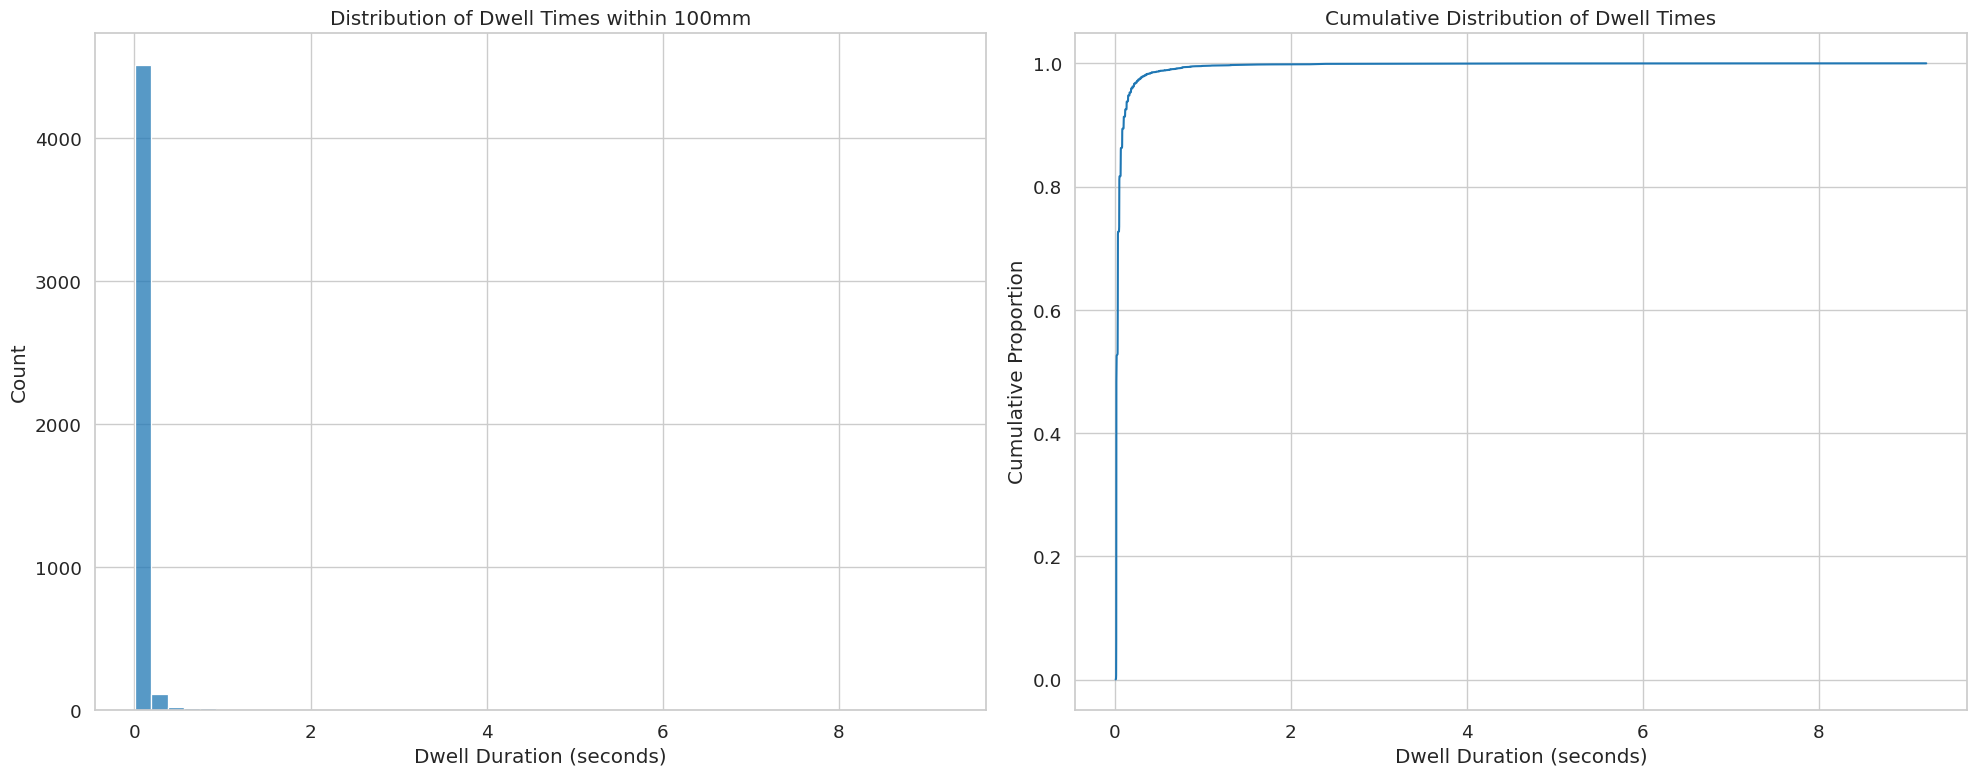

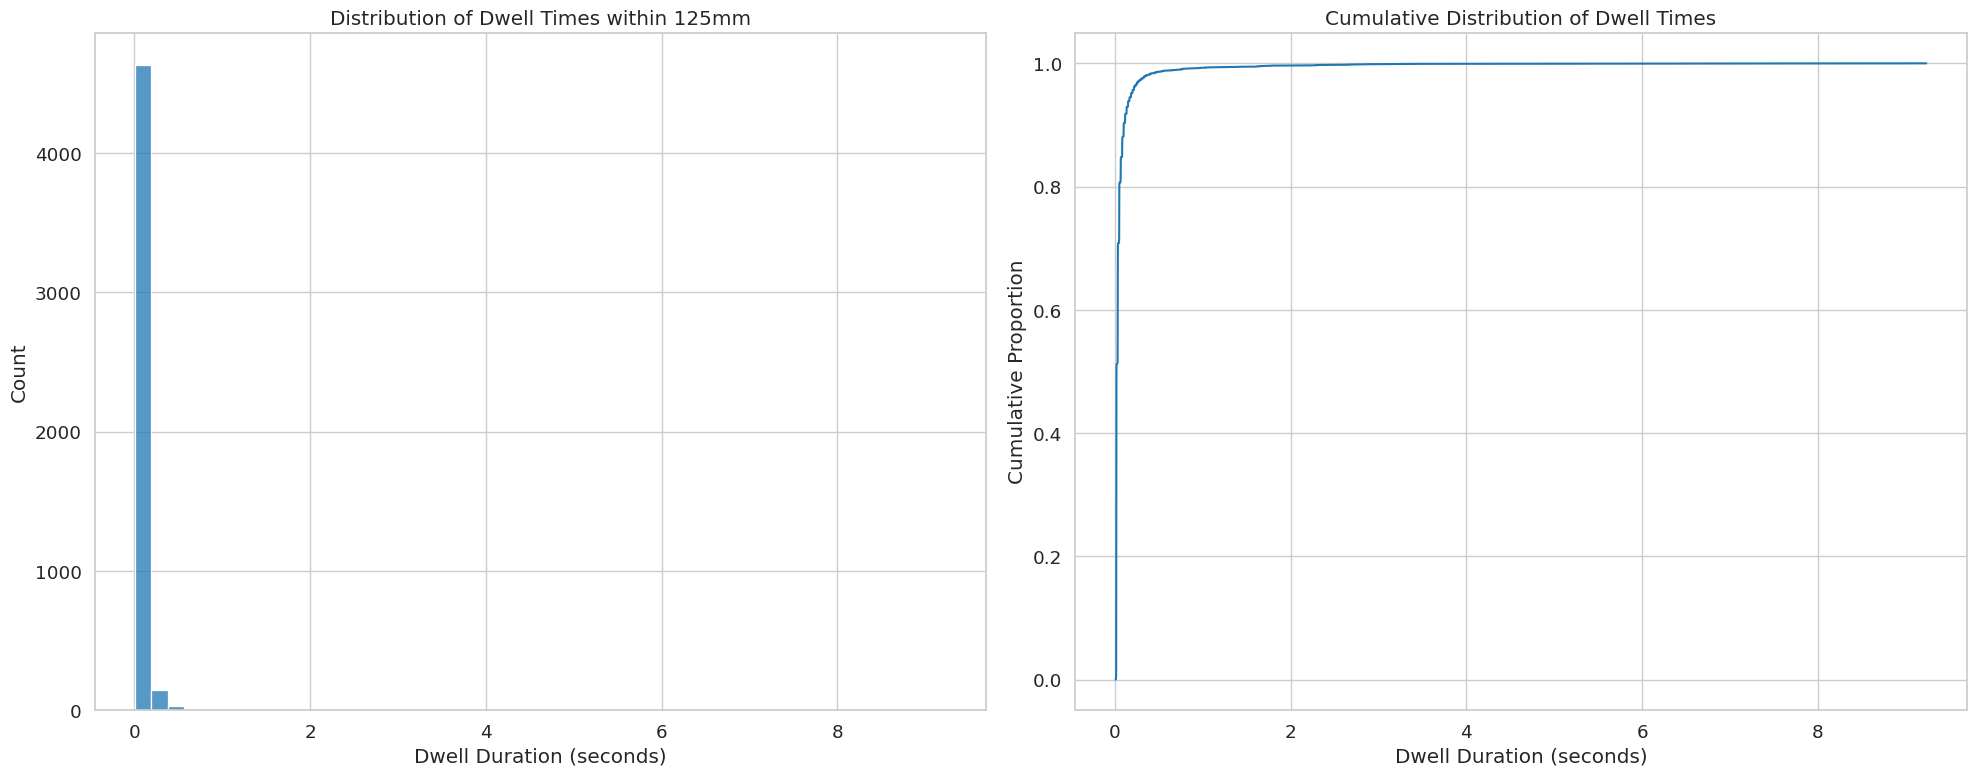

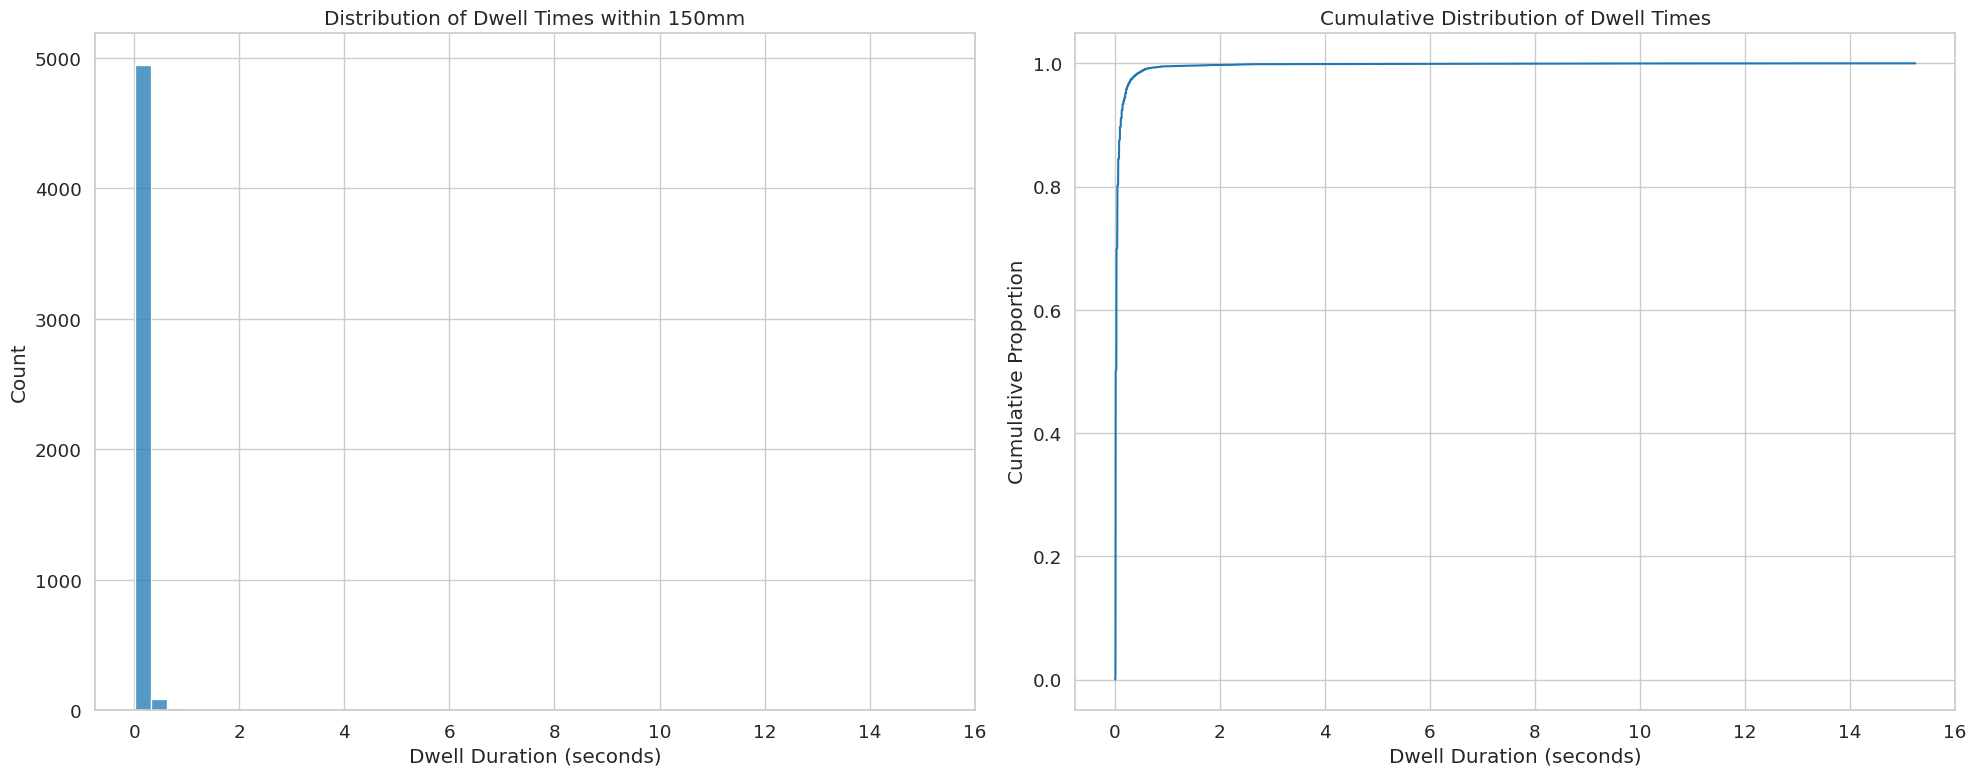

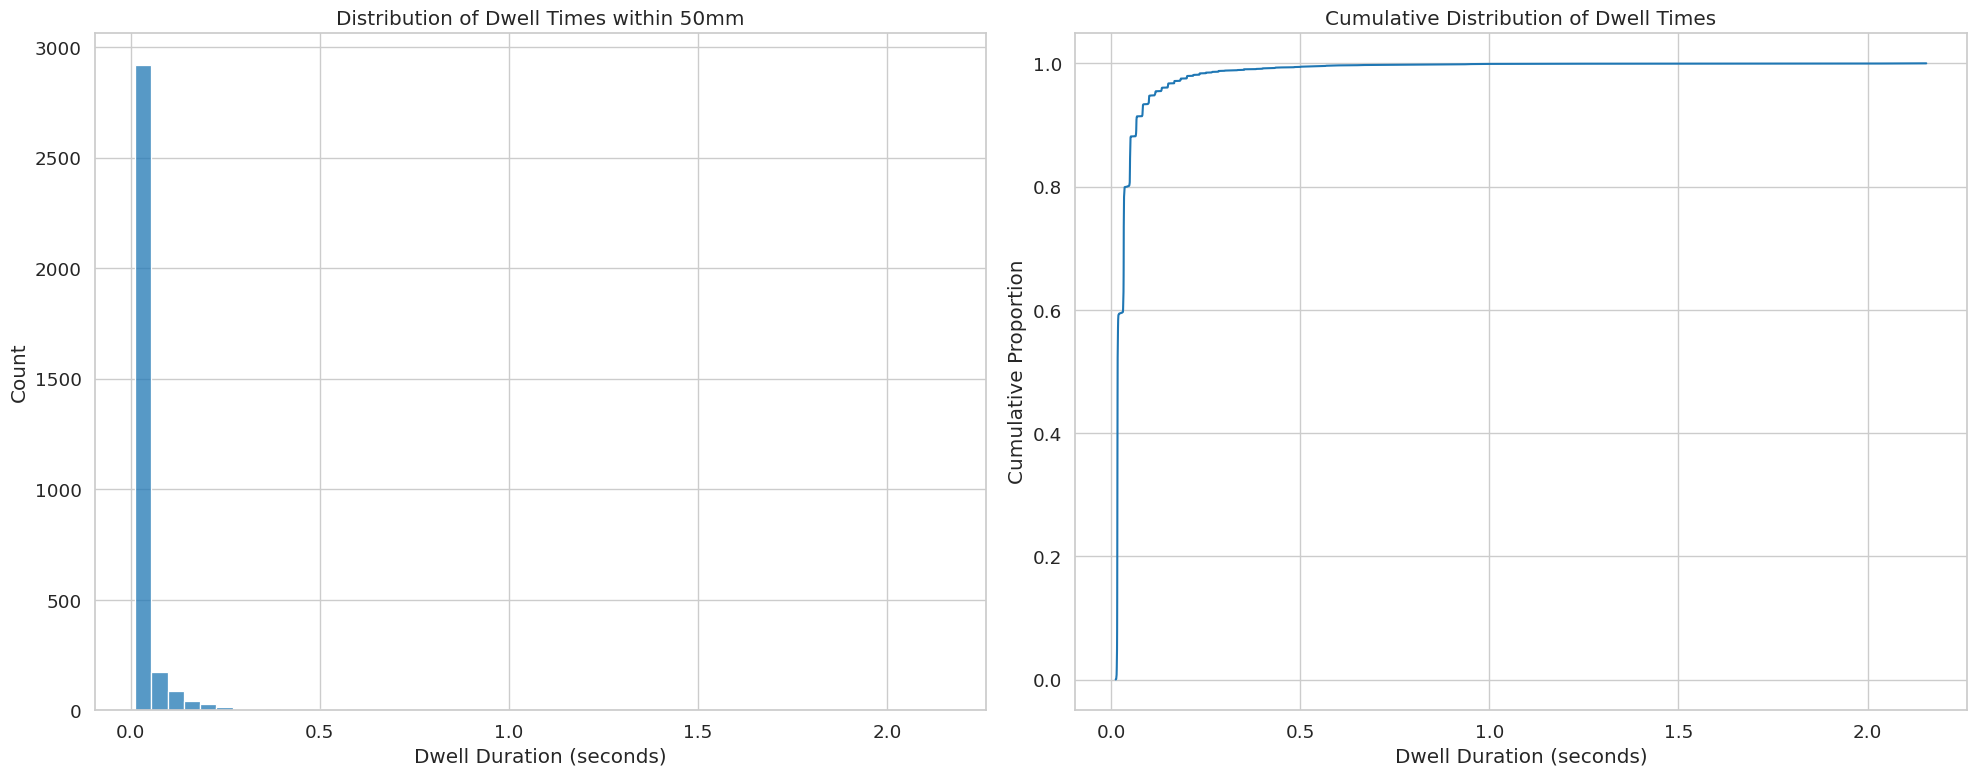

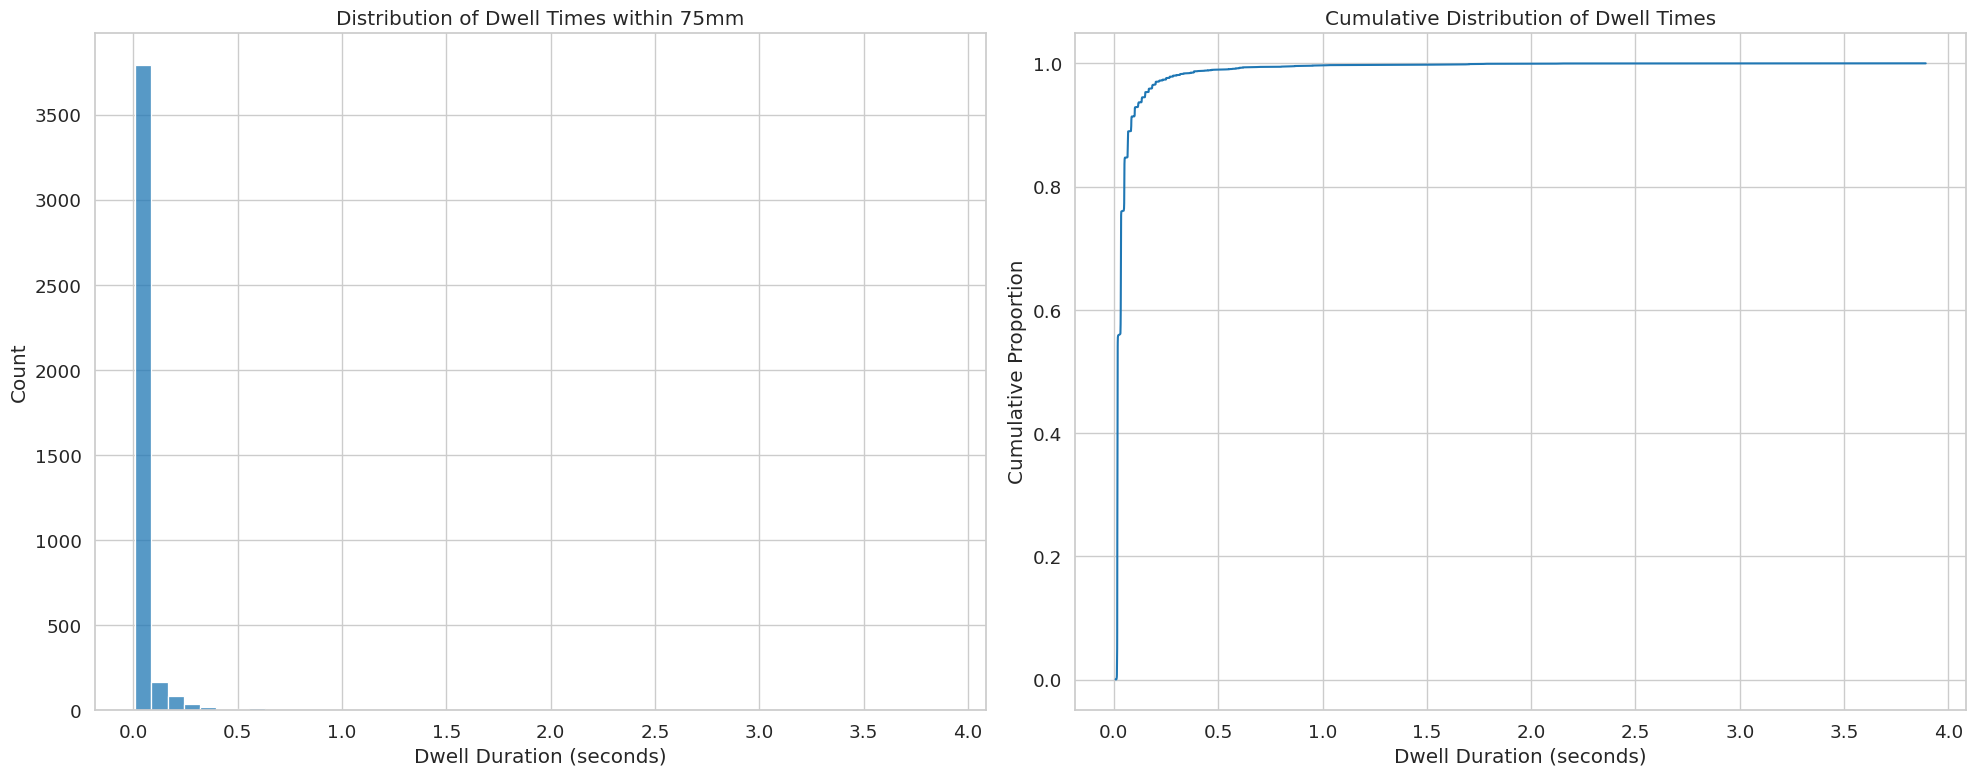

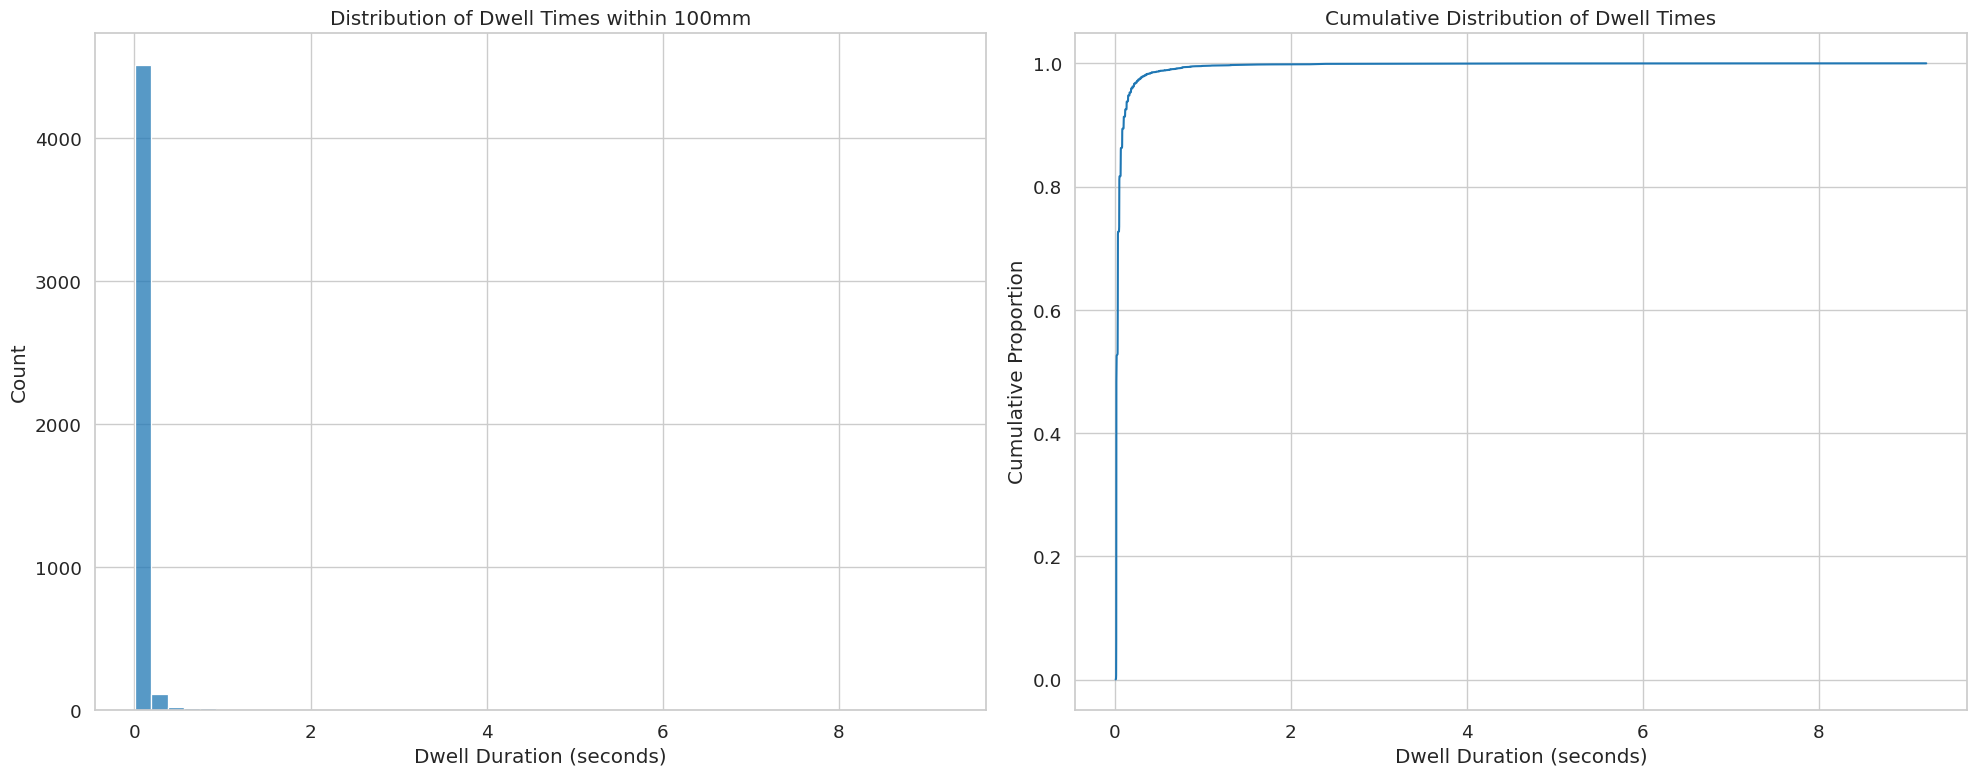

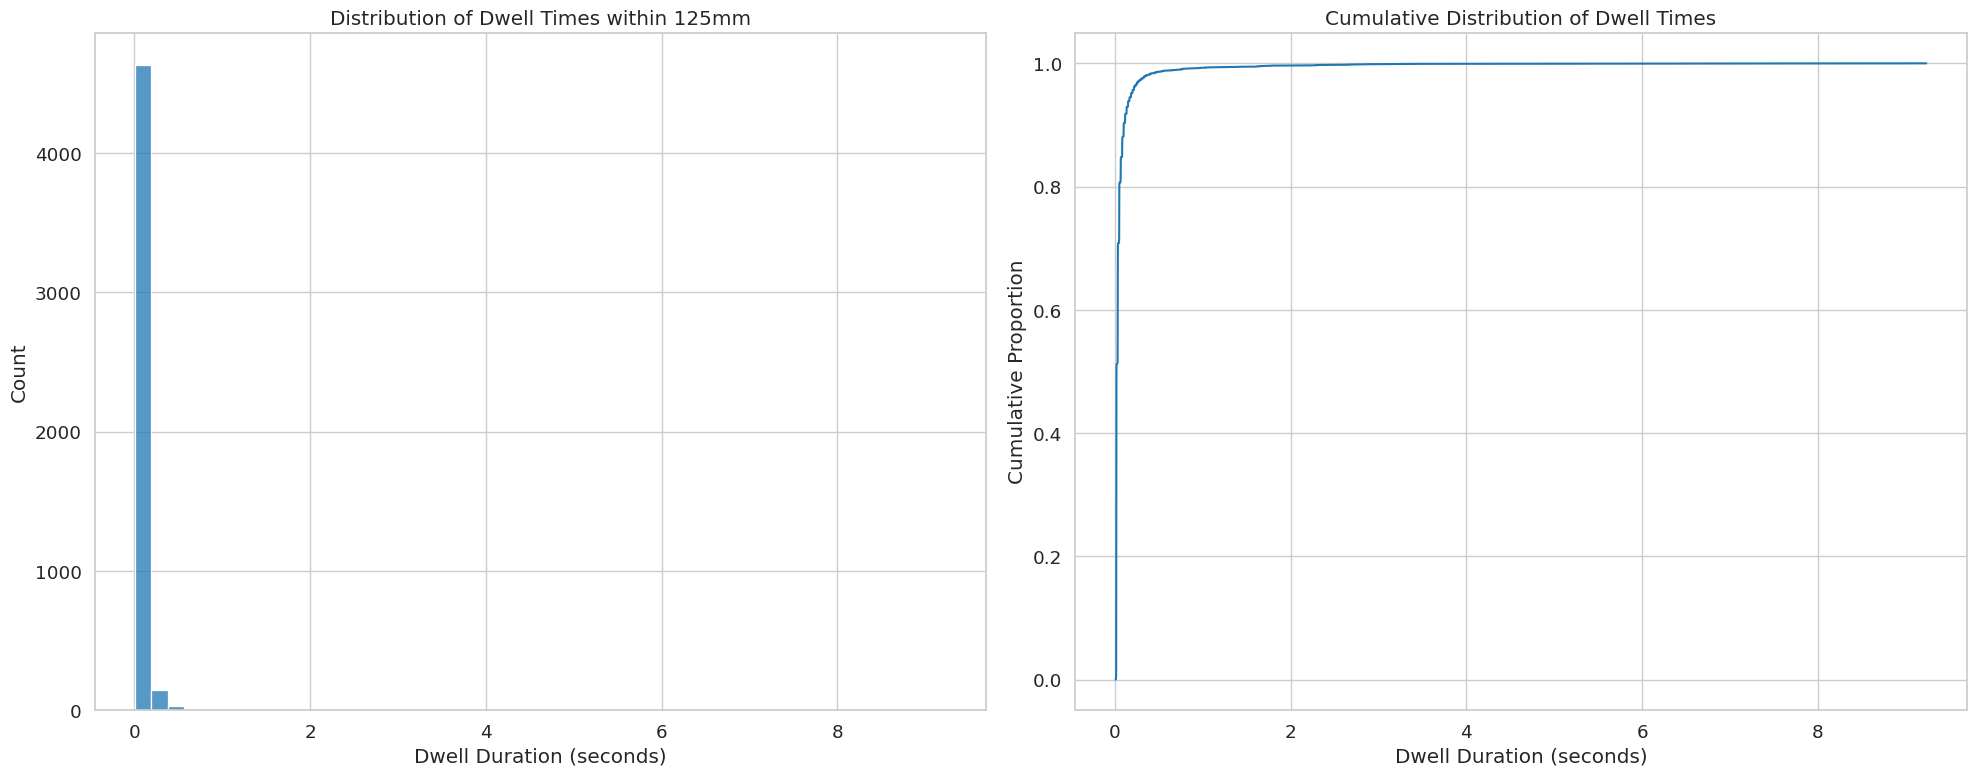

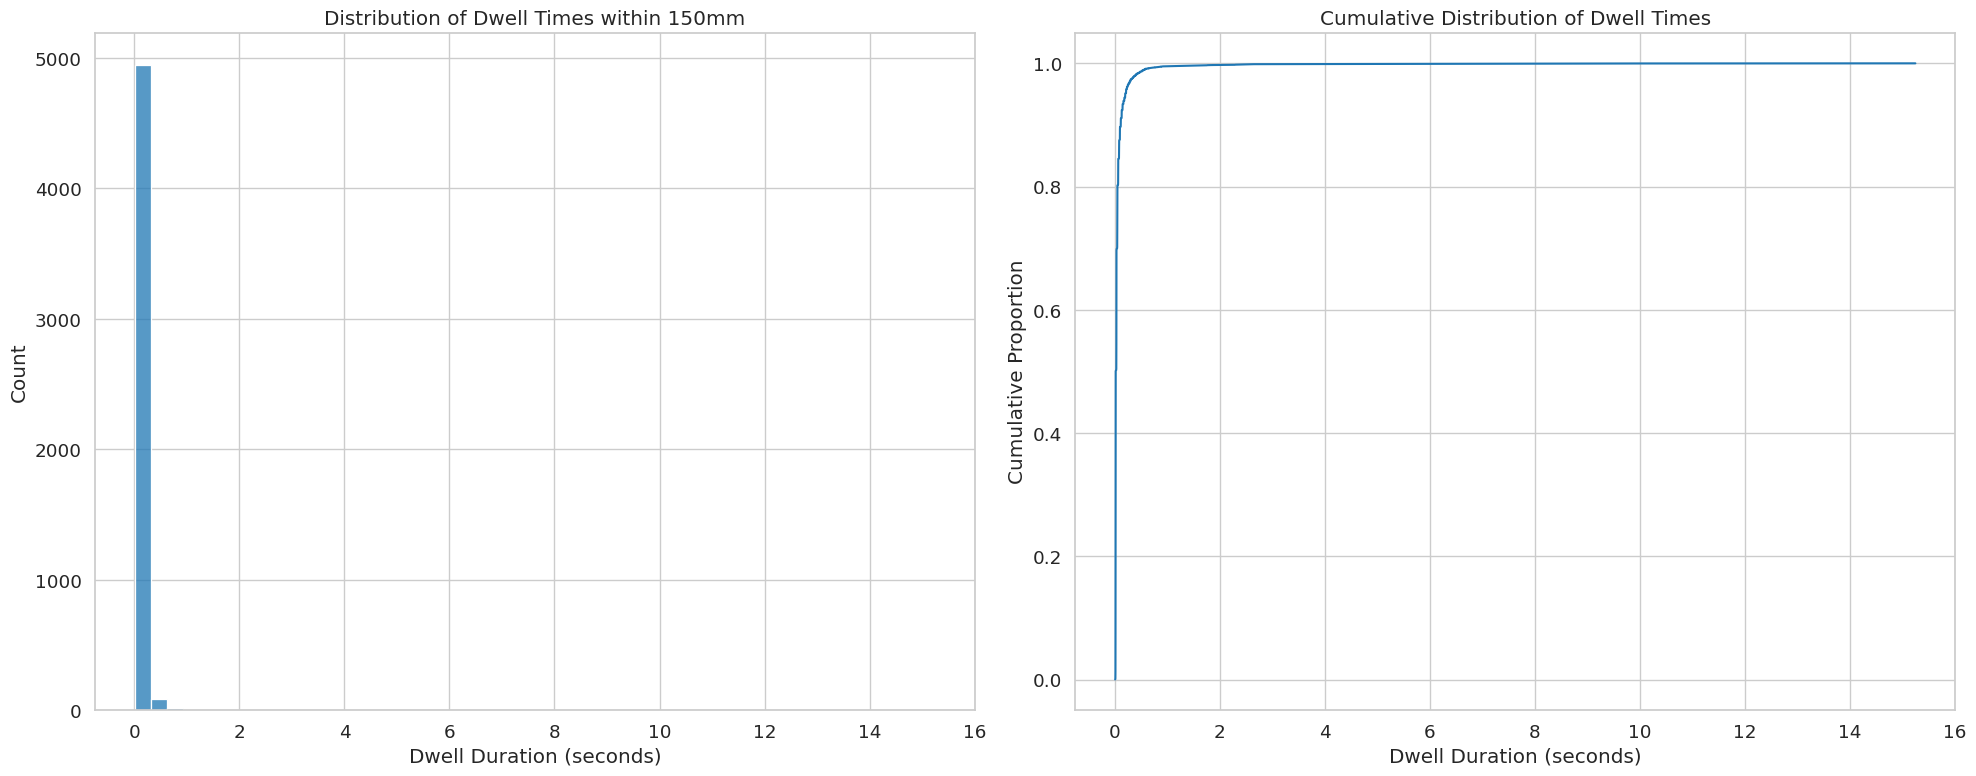

In [13]:
def plot_combined_dwell_analysis(debug_df, thresholds=[0.05, 0.075, 0.1, 0.125, 0.15]):
    """
    Create combined visualization of dwell times for different thresholds
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Colors for different thresholds
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))

    # Plot 1: Distribution of dwell times (focused on 0-0.5s range)
    for threshold, color in zip(thresholds, colors):
        _, periods = analyze_gaze_dwell_times(debug_df, threshold)
        sns.histplot(data=periods[periods <= 0.5],
                    bins=50,
                    alpha=0.5,
                    color=color,
                    label=f'{int(threshold*1000)}mm',
                    ax=ax1)

    ax1.set_title('Distribution of Dwell Times (0-0.5s)')
    ax1.set_xlabel('Dwell Duration (seconds)')
    ax1.set_ylabel('Count')
    ax1.legend(title='Proximity Threshold')

    # Plot 2: Cumulative distribution (log scale for better detail)
    for threshold, color in zip(thresholds, colors):
        _, periods = analyze_gaze_dwell_times(debug_df, threshold)
        sorted_dwells = np.sort(periods)
        cumulative = np.arange(1, len(sorted_dwells) + 1) / len(sorted_dwells)
        ax2.plot(sorted_dwells, cumulative,
                color=color,
                label=f'{int(threshold*1000)}mm')

    ax2.set_title('Cumulative Distribution of Dwell Times')
    ax2.set_xlabel('Dwell Duration (seconds)')
    ax2.set_ylabel('Cumulative Proportion')
    ax2.set_xscale('log')  # Log scale to better show distribution
    ax2.grid(True)
    ax2.legend(title='Proximity Threshold')

    # Add vertical line for 0.5s threshold
    ax2.axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='0.5s threshold')

    plt.tight_layout()

    return fig

# Create the combined visualization
plot_combined_dwell_analysis(debug_df)

# 9. Scene-Level Activation Analysis: Testing Practical Interaction Parameters

This analysis examines how different proximity thresholds affect activation success rates across scenes, using a 1-second dwell time requirement to simulate real-world interaction scenarios.

## Activation Results by Proximity Zone:

### 100mm Zone (Precise):
- Total Activations: 22
- Scenes with Activations: 8/100 (8%)
- Max per Scene: 6
- Average per Scene: 0.22

### 200mm Zone (Standard):
- Total Activations: 45
- Scenes with Activations: 18/100 (18%)
- Max per Scene: 5
- Average per Scene: 0.45

### 300mm Zone (Extended):
- Total Activations: 80
- Scenes with Activations: 28/100 (28%)
- Max per Scene: 6
- Average per Scene: 0.80

## Key Insights:

1. Activation Success:
   * Larger zones significantly increase success rate
   * Linear growth in total activations with zone size
   * Consistent maximum activations (5-6) across zones

2. Scene Coverage:
   * 100mm: Limited coverage (8% of scenes)
   * 200mm: Moderate improvement (18% of scenes)
   * 300mm: Best coverage (28% of scenes)

## Design Implications:

1. Zone Selection Trade-offs:
   * Precision (100mm): High confidence but limited success
   * Balance (200mm): Moderate success with good precision
   * Accessibility (300mm): Higher success but potential false positives

2. Implementation Recommendations:
   * Consider adaptive zones based on target size
   * Implement progressive feedback during dwell
   * Balance between accessibility and precision


Results for 100mm proximity threshold:
Total activations across all scenes: 22
Number of scenes with at least one activation: 8/100
Maximum activations in any scene: 6
Average activations per scene: 0.22

Results for 200mm proximity threshold:
Total activations across all scenes: 45
Number of scenes with at least one activation: 18/100
Maximum activations in any scene: 5
Average activations per scene: 0.45

Results for 300mm proximity threshold:
Total activations across all scenes: 80
Number of scenes with at least one activation: 28/100
Maximum activations in any scene: 6
Average activations per scene: 0.80


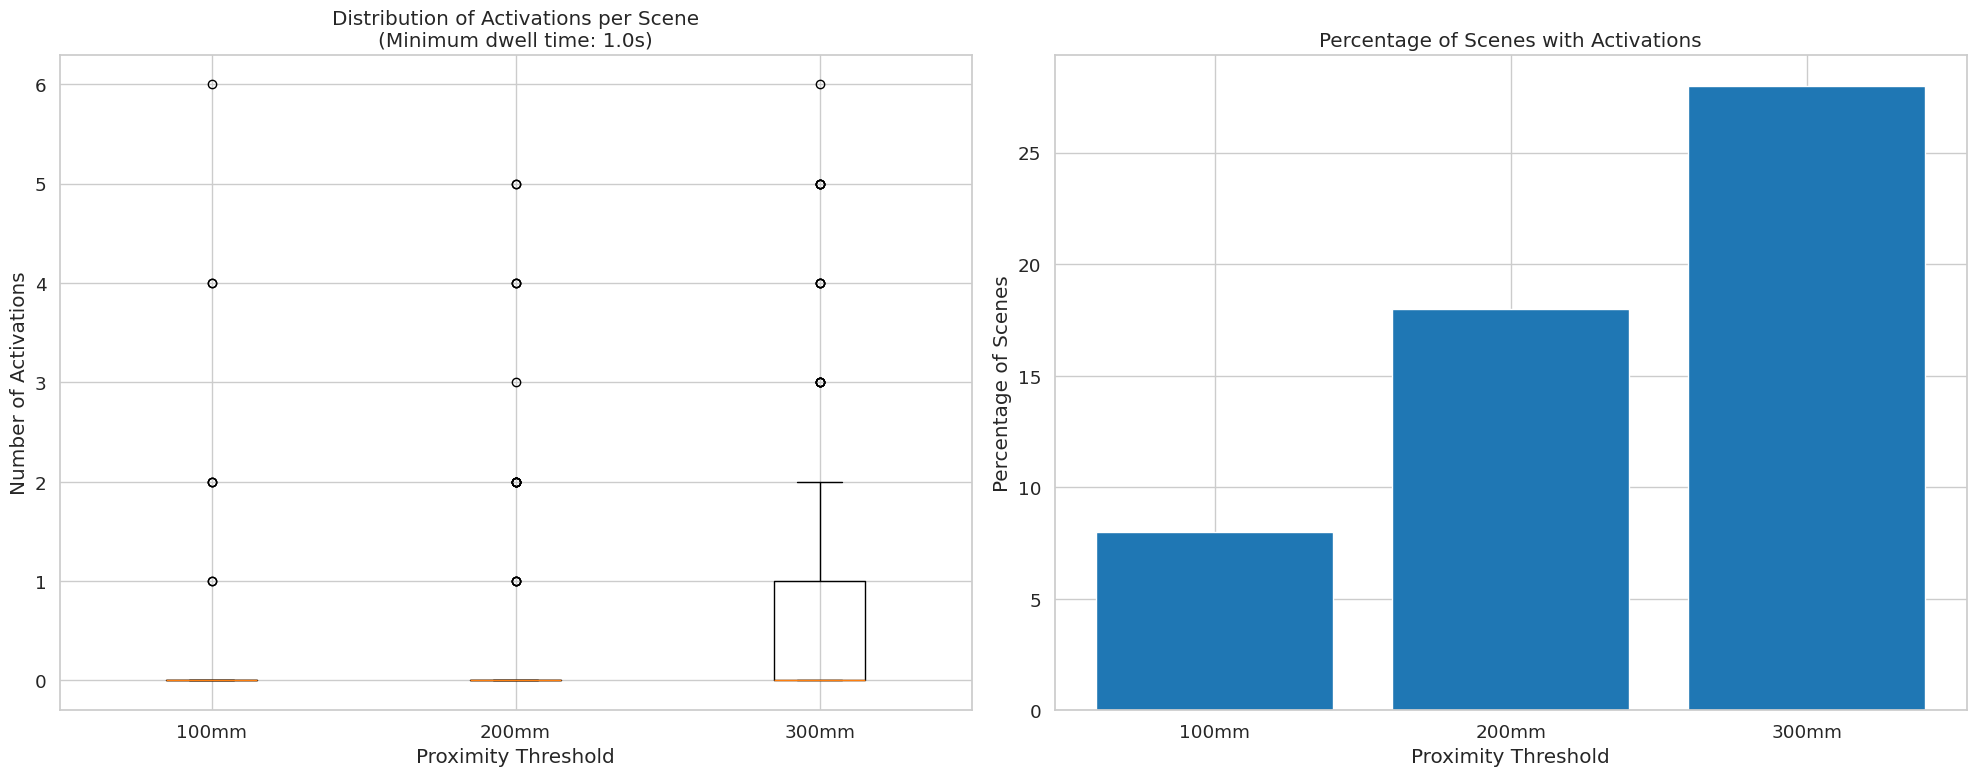

In [14]:
def analyze_activations_per_scene(debug_df, proximity_thresholds=[0.1, 0.2, 0.3], dwell_threshold=1.0):
    """
    Analyze how many activations would occur in each scene given different proximity thresholds
    and a minimum dwell time of 1 second
    """
    results = {}

    # Sort by scene and time
    debug_df = debug_df.sort_values(['scene_name', 'time_from_start'])

    for proximity in proximity_thresholds:
        scene_activations = []

        for scene_name in debug_df['scene_name'].unique():
            scene_data = debug_df[debug_df['scene_name'] == scene_name].copy()

            # Calculate 3D distance for each point
            scene_data['distance_3d'] = np.sqrt(
                scene_data['relative_gaze_x']**2 +
                scene_data['relative_gaze_y']**2 +
                scene_data['relative_gaze_z']**2
            )

            # Initialize variables for tracking dwell periods
            current_dwell_start = None
            activations = 0

            for idx, row in scene_data.iterrows():
                within_threshold = row['distance_3d'] <= proximity

                if within_threshold and current_dwell_start is None:
                    # Start of new dwell period
                    current_dwell_start = row['time_from_start']
                elif not within_threshold and current_dwell_start is not None:
                    # End of dwell period - check if it was long enough
                    dwell_duration = row['time_from_start'] - current_dwell_start
                    if dwell_duration >= dwell_threshold:
                        activations += 1
                    current_dwell_start = None

            # Check final dwell period if it exists
            if current_dwell_start is not None:
                dwell_duration = scene_data['time_from_start'].iloc[-1] - current_dwell_start
                if dwell_duration >= dwell_threshold:
                    activations += 1

            scene_activations.append(activations)

        results[f'{int(proximity*1000)}mm'] = {
            'total_activations': sum(scene_activations),
            'scenes_with_activations': len([a for a in scene_activations if a > 0]),
            'max_activations_in_scene': max(scene_activations),
            'average_activations_per_scene': np.mean(scene_activations),
            'activation_distribution': scene_activations
        }

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Distribution of activations per scene for each threshold
    data_to_plot = []
    labels = []
    for threshold, data in results.items():
        data_to_plot.append(data['activation_distribution'])
        labels.append(threshold)

    ax1.boxplot(data_to_plot, labels=labels)
    ax1.set_title(f'Distribution of Activations per Scene\n(Minimum dwell time: {dwell_threshold}s)')
    ax1.set_xlabel('Proximity Threshold')
    ax1.set_ylabel('Number of Activations')

    # Plot 2: Percentage of scenes with activations
    thresholds = list(results.keys())
    percentages = [data['scenes_with_activations'] / len(debug_df['scene_name'].unique()) * 100
                  for data in results.values()]

    ax2.bar(thresholds, percentages)
    ax2.set_title('Percentage of Scenes with Activations')
    ax2.set_xlabel('Proximity Threshold')
    ax2.set_ylabel('Percentage of Scenes')

    plt.tight_layout()

    return results

# Run the analysis
activation_results = analyze_activations_per_scene(debug_df)

# Print detailed results
for threshold, data in activation_results.items():
    print(f"\nResults for {threshold} proximity threshold:")
    print(f"Total activations across all scenes: {data['total_activations']}")
    print(f"Number of scenes with at least one activation: {data['scenes_with_activations']}/100")
    print(f"Maximum activations in any scene: {data['max_activations_in_scene']}")
    print(f"Average activations per scene: {data['average_activations_per_scene']:.2f}")

# 10. Extended Activation Analysis: Fine-Tuning the Interaction Zone

This analysis expands our understanding of activation patterns across a broader range of proximity thresholds (100mm-500mm), providing detailed insights for optimizing interaction parameters.

## Comprehensive Activation Statistics:

### Key Thresholds:
- 100mm: 22 activations (8% of scenes, avg 0.22/scene)
- 250mm: 77 activations (24% of scenes, avg 0.77/scene)
- 500mm: 105 activations (39% of scenes, avg 1.05/scene)

## Visualization Components:

1. Activation Distribution:
   * Box plots showing activation patterns per threshold
   * Consistent maximum activations (6-8 per scene)
   * Increasing median activations with larger zones

2. Scene Coverage:
   * Linear increase in scene activation percentage
   * 100mm: 8% → 500mm: 39% of scenes
   * Diminishing returns after 300mm

3. Average Activations:
   * Nearly linear growth from 100mm to 500mm
   * Significant jump between 150mm-250mm
   * Stabilization trend after 400mm

## Key Insights:

1. Optimal Zones:
   * 200-250mm shows best efficiency/precision balance
   * Significant improvement over 100mm baseline
   * Manageable false positive risk

2. Performance Patterns:
   * Consistent maximum activations across zones
   * Predictable scaling of success rates
   * Clear threshold effects around 250mm

## Design Recommendations:
1. Primary Zone: 200-250mm
   * Balances success rate with precision
   * Captures meaningful interactions
   * Manageable false positive rate

2. Implementation Strategy:
   * Consider progressive activation zones
   * Implement confidence weighting by proximity
   * Account for scene-specific requirements


Detailed Activation Analysis (1-second dwell time requirement):
--------------------------------------------------------------------------------
Threshold  Total    Scenes w/Act    Max/Scene    Avg/Scene 
--------------------------------------------------------------------------------
100mm      22       8               6            0.22
150mm      29       12              6            0.29
200mm      45       18              5            0.45
250mm      77       24              8            0.77
300mm      80       28              6            0.80
350mm      84       30              7            0.84
400mm      92       32              7            0.92
450mm      99       36              7            0.99
500mm      105      39              7            1.05


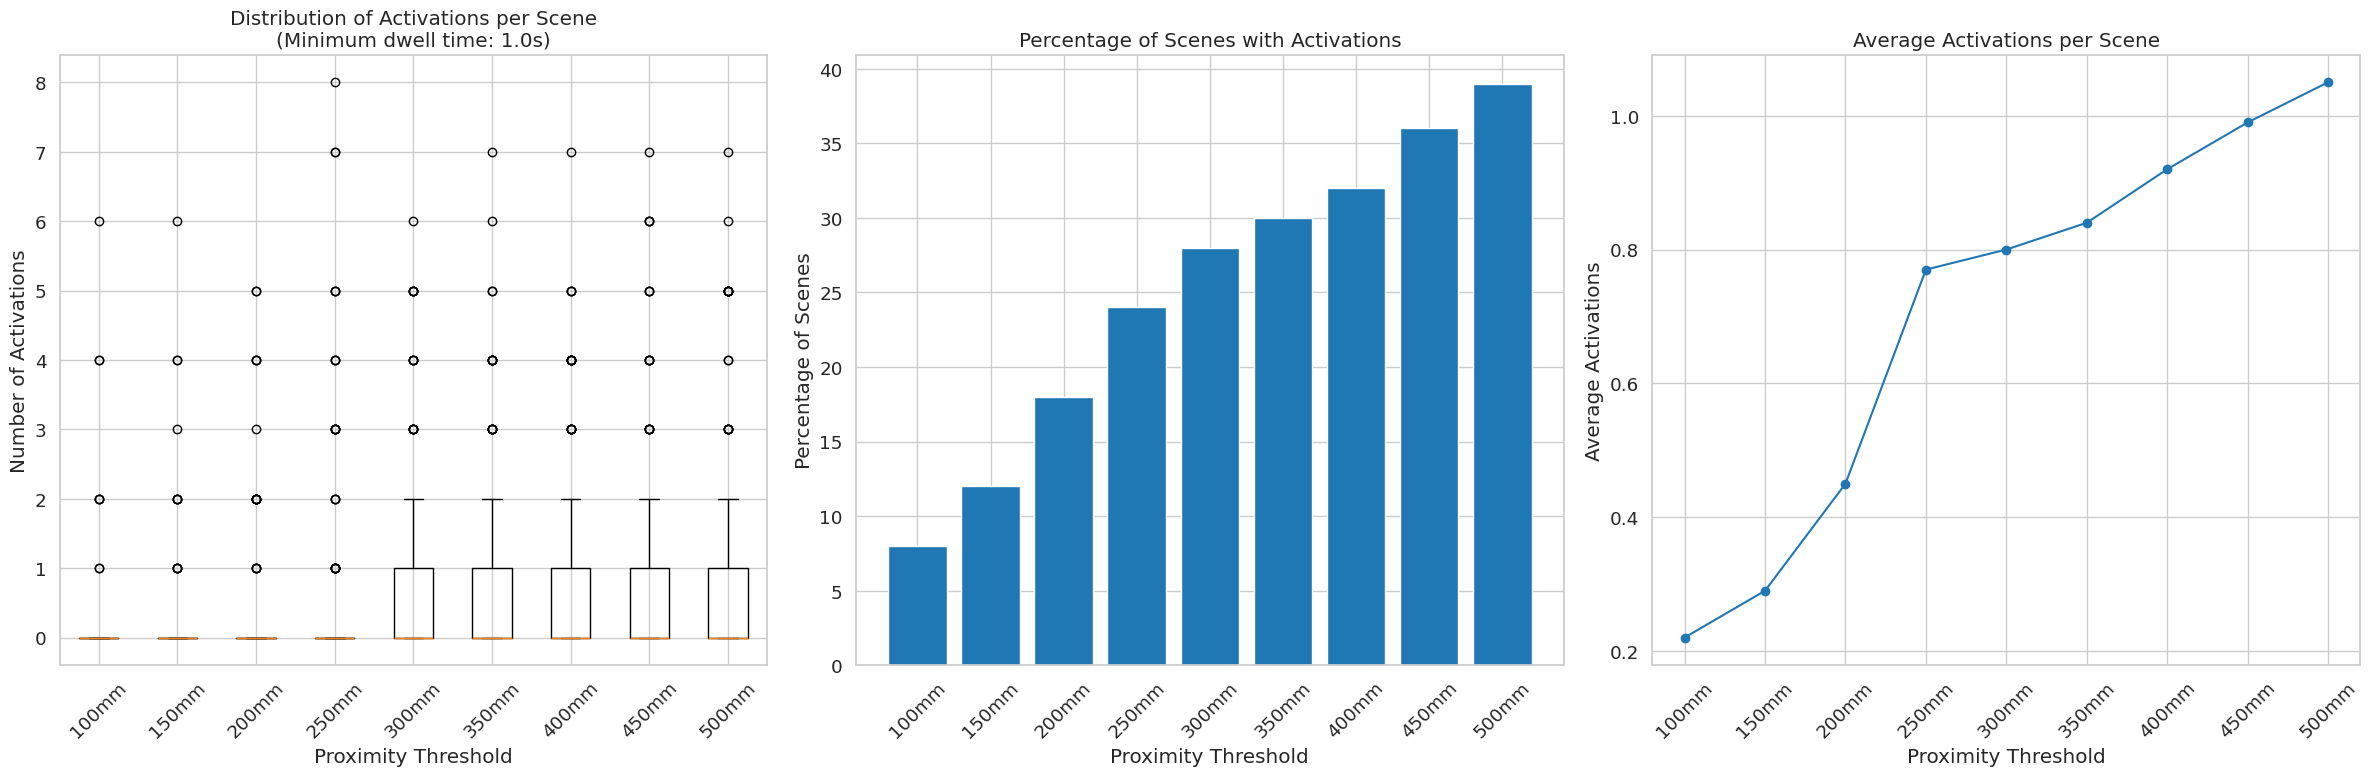

In [15]:
def analyze_activations_per_scene(debug_df,
                                proximity_thresholds=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                                dwell_threshold=1.0):
    """
    Analyze how many activations would occur in each scene given different proximity thresholds
    and a minimum dwell time of 1 second
    """
    results = {}

    # Sort by scene and time
    debug_df = debug_df.sort_values(['scene_name', 'time_from_start'])

    for proximity in proximity_thresholds:
        scene_activations = []

        for scene_name in debug_df['scene_name'].unique():
            scene_data = debug_df[debug_df['scene_name'] == scene_name].copy()

            # Calculate 3D distance for each point
            scene_data['distance_3d'] = np.sqrt(
                scene_data['relative_gaze_x']**2 +
                scene_data['relative_gaze_y']**2 +
                scene_data['relative_gaze_z']**2
            )

            # Initialize variables for tracking dwell periods
            current_dwell_start = None
            activations = 0

            for idx, row in scene_data.iterrows():
                within_threshold = row['distance_3d'] <= proximity

                if within_threshold and current_dwell_start is None:
                    # Start of new dwell period
                    current_dwell_start = row['time_from_start']
                elif not within_threshold and current_dwell_start is not None:
                    # End of dwell period - check if it was long enough
                    dwell_duration = row['time_from_start'] - current_dwell_start
                    if dwell_duration >= dwell_threshold:
                        activations += 1
                    current_dwell_start = None

            # Check final dwell period if it exists
            if current_dwell_start is not None:
                dwell_duration = scene_data['time_from_start'].iloc[-1] - current_dwell_start
                if dwell_duration >= dwell_threshold:
                    activations += 1

            scene_activations.append(activations)

        results[f'{int(proximity*1000)}mm'] = {
            'total_activations': sum(scene_activations),
            'scenes_with_activations': len([a for a in scene_activations if a > 0]),
            'max_activations_in_scene': max(scene_activations),
            'average_activations_per_scene': np.mean(scene_activations),
            'activation_distribution': scene_activations
        }

    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: Distribution of activations per scene for each threshold
    data_to_plot = []
    labels = []
    for threshold, data in results.items():
        data_to_plot.append(data['activation_distribution'])
        labels.append(threshold)

    ax1.boxplot(data_to_plot, labels=labels)
    ax1.set_title(f'Distribution of Activations per Scene\n(Minimum dwell time: {dwell_threshold}s)')
    ax1.set_xlabel('Proximity Threshold')
    ax1.set_ylabel('Number of Activations')
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Percentage of scenes with activations
    thresholds = list(results.keys())
    percentages = [data['scenes_with_activations'] / len(debug_df['scene_name'].unique()) * 100
                  for data in results.values()]

    ax2.bar(thresholds, percentages)
    ax2.set_title('Percentage of Scenes with Activations')
    ax2.set_xlabel('Proximity Threshold')
    ax2.set_ylabel('Percentage of Scenes')
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Average activations per scene
    averages = [data['average_activations_per_scene'] for data in results.values()]
    ax3.plot(thresholds, averages, marker='o')
    ax3.set_title('Average Activations per Scene')
    ax3.set_xlabel('Proximity Threshold')
    ax3.set_ylabel('Average Activations')
    ax3.grid(True)
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()

    return results

# Run the analysis
activation_results = analyze_activations_per_scene(debug_df)

# Print detailed results
print("\nDetailed Activation Analysis (1-second dwell time requirement):")
print("-" * 80)
print(f"{'Threshold':<10} {'Total':<8} {'Scenes w/Act':<15} {'Max/Scene':<12} {'Avg/Scene':<10}")
print("-" * 80)
for threshold, data in activation_results.items():
    print(f"{threshold:<10} {data['total_activations']:<8} {data['scenes_with_activations']:<15} "
          f"{data['max_activations_in_scene']:<12} {data['average_activations_per_scene']:.2f}")

# 11. Extended Dwell Time Analysis: Impact of Increased Activation Requirements

This analysis examines how doubling the dwell time requirement to 2 seconds affects activation patterns across different proximity thresholds, providing insights into the trade-off between interaction confidence and accessibility.

## Comparative Analysis (1s vs 2s Dwell):

### 100mm Zone:
- 1s: 22 activations (8% of scenes)
- 2s: 10 activations (6% of scenes)
- Impact: 55% reduction in activations

### 250mm Zone:
- 1s: 77 activations (24% of scenes)
- 2s: 32 activations (19% of scenes)
- Impact: 58% reduction in activations

### 500mm Zone:
- 1s: 105 activations (39% of scenes)
- 2s: 58 activations (32% of scenes)
- Impact: 45% reduction in activations

## Key Observations:

1. Activation Patterns:
   * Maximum activations per scene reduced (7-8 → 3-5)
   * More consistent activation counts across zones
   * Smoother progression in success rates

2. Scene Coverage:
   * Still shows linear growth with zone size
   * Lower overall coverage percentages
   * Plateaus earlier (around 350mm)

3. Performance Impact:
   * Roughly 50% reduction in total activations
   * More pronounced effect in smaller zones
   * More stable activation patterns

## Design Implications:

1. Dwell Time Selection:
   * 2s provides higher confidence in intentional activation
   * Significant cost to interaction accessibility
   * May be too restrictive for general use

2. Recommendations:
   * Use 1s dwell for general interactions
   * Consider 2s for critical/destructive actions
   * Implement progressive feedback during dwell
   * Consider adaptive dwell times based on context


Detailed Activation Analysis (2-second dwell time requirement):
--------------------------------------------------------------------------------
Threshold  Total    Scenes w/Act    Max/Scene    Avg/Scene 
--------------------------------------------------------------------------------
100mm      10       6               3            0.10
150mm      18       10              3            0.18
200mm      20       12              3            0.20
250mm      32       19              3            0.32
300mm      31       21              3            0.31
350mm      52       29              5            0.52
400mm      54       29              4            0.54
450mm      54       29              4            0.54
500mm      58       32              4            0.58


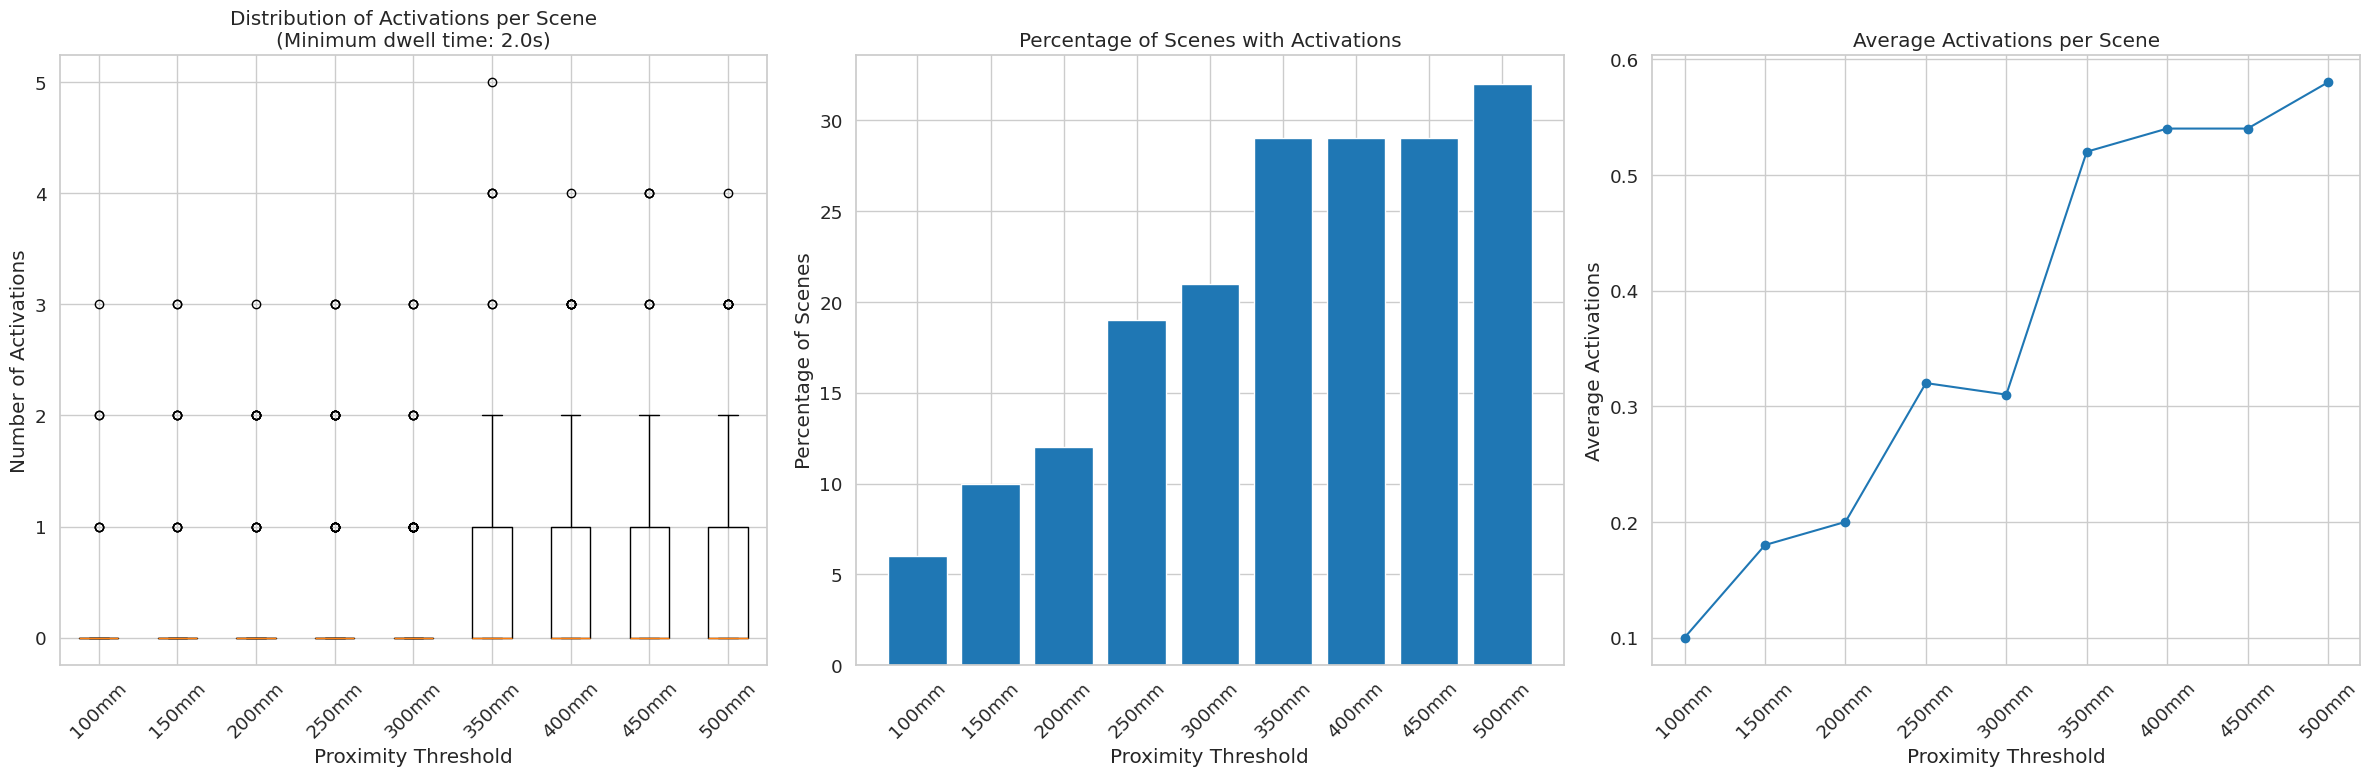

In [16]:
# Run the same analysis with 2-second dwell time
activation_results_2s = analyze_activations_per_scene(debug_df,
                                                    proximity_thresholds=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                                                    dwell_threshold=2.0)

# Print detailed results
print("\nDetailed Activation Analysis (2-second dwell time requirement):")
print("-" * 80)
print(f"{'Threshold':<10} {'Total':<8} {'Scenes w/Act':<15} {'Max/Scene':<12} {'Avg/Scene':<10}")
print("-" * 80)
for threshold, data in activation_results_2s.items():
    print(f"{threshold:<10} {data['total_activations']:<8} {data['scenes_with_activations']:<15} "
          f"{data['max_activations_in_scene']:<12} {data['average_activations_per_scene']:.2f}")

# 12. Maximum Dwell Analysis: Testing the Limits of Intentional Interaction

This analysis examines the impact of a 3-second dwell requirement, representing the upper bound of practical gaze-based interaction timing.

## Comparative Analysis Across Dwell Times:

### 100mm Zone:
- 1s: 22 activations (8% of scenes)
- 2s: 10 activations (6% of scenes)
- 3s: 6 activations (3% of scenes)

### 300mm Zone:
- 1s: 80 activations (28% of scenes)
- 2s: 31 activations (21% of scenes)
- 3s: 26 activations (18% of scenes)

### 500mm Zone:
- 1s: 105 activations (39% of scenes)
- 2s: 58 activations (32% of scenes)
- 3s: 42 activations (29% of scenes)

## Key Findings:

1. Activation Reduction:
   * Severe reduction in total activations
   * Maximum activations per scene: 2-3
   * Linear growth pattern maintained

2. Scene Coverage:
   * Significant drop in coverage percentages
   * More pronounced effect in smaller zones
   * Still shows zone size dependency

3. Stability Patterns:
   * More consistent activation counts
   * Reduced variability between scenes
   * Clearer intentionality signal

## Design Implications:

1. Use Case Considerations:
   * 3s dwell: Suitable for critical operations only
   * Requires larger activation zones (400mm+)
   * Need for clear visual feedback

2. Recommendations:
   * Avoid 3s dwell for general interactions
   * Consider for security-critical actions
   * Implement clear progress indicators
   * Use larger zones to compensate for timing


Detailed Activation Analysis (2-second dwell time requirement):
--------------------------------------------------------------------------------
Threshold  Total    Scenes w/Act    Max/Scene    Avg/Scene 
--------------------------------------------------------------------------------
100mm      6        3               2            0.06
150mm      11       7               2            0.11
200mm      14       9               2            0.14
250mm      20       14              2            0.20
300mm      26       18              3            0.26
350mm      28       20              3            0.28
400mm      40       26              3            0.40
450mm      39       28              3            0.39
500mm      42       29              3            0.42


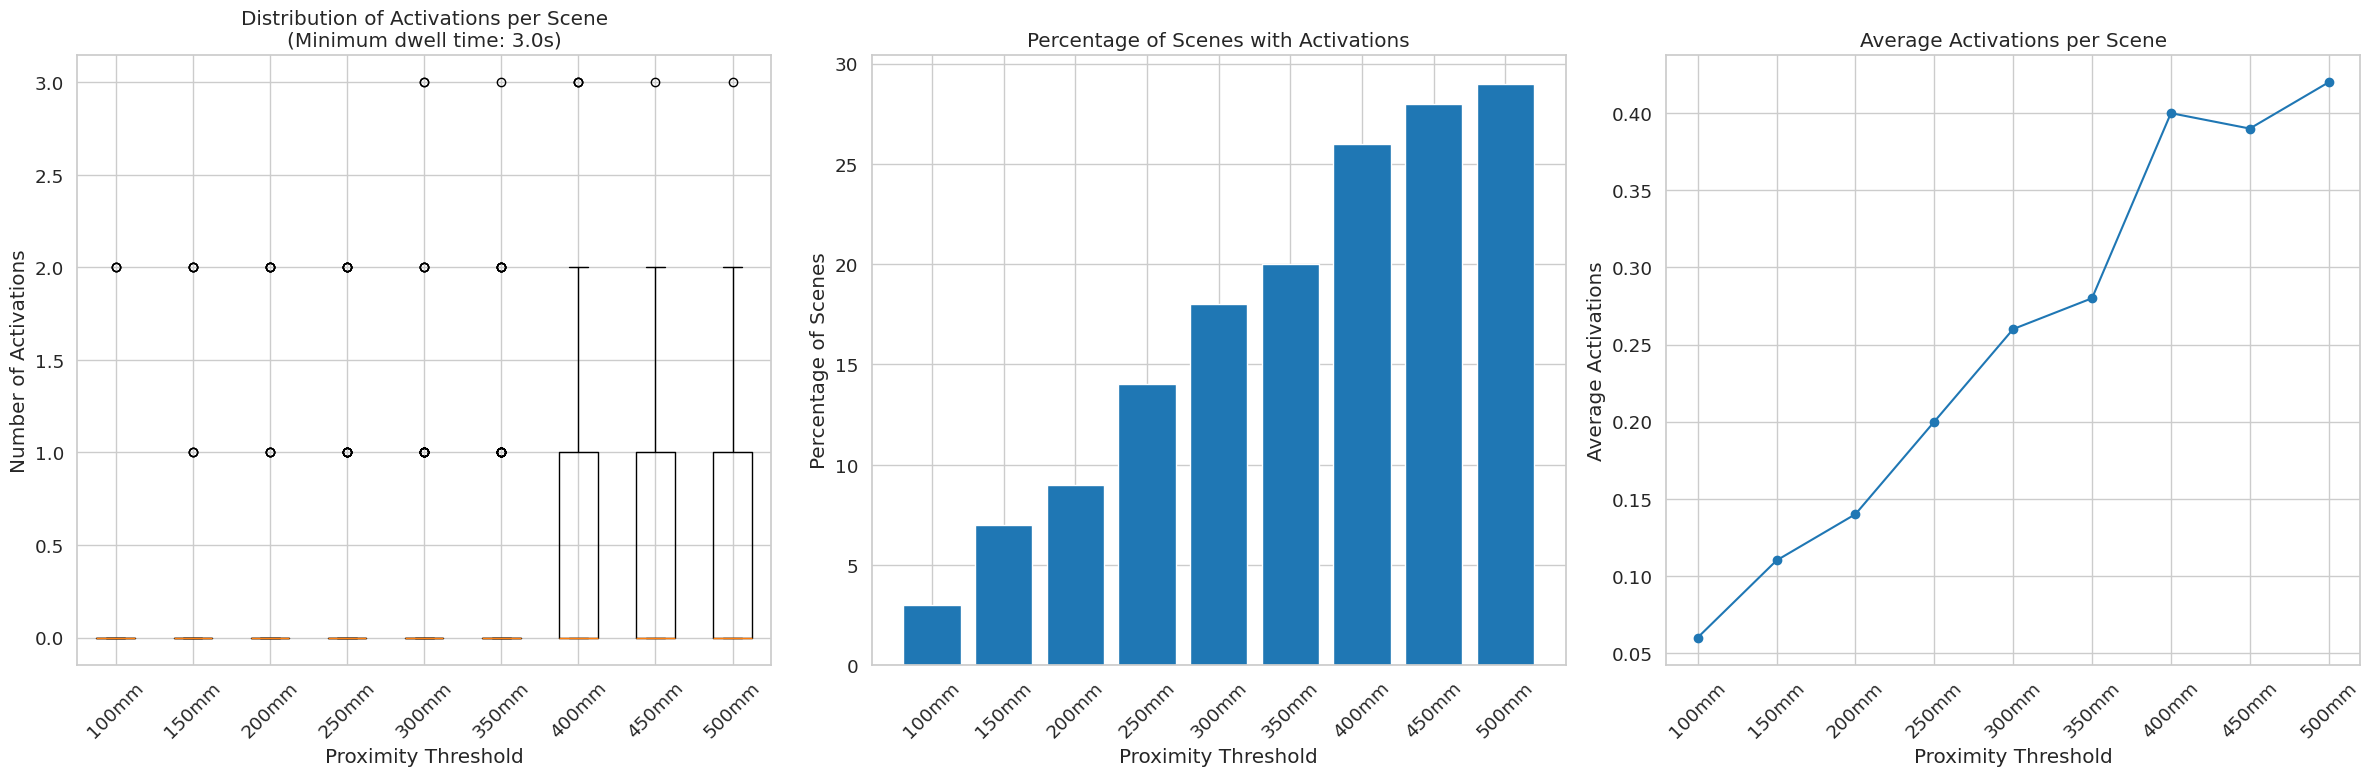

In [17]:
# Run the same analysis with 2-second dwell time
activation_results_2s = analyze_activations_per_scene(debug_df,
                                                    proximity_thresholds=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                                                    dwell_threshold=3.0)

# Print detailed results
print("\nDetailed Activation Analysis (2-second dwell time requirement):")
print("-" * 80)
print(f"{'Threshold':<10} {'Total':<8} {'Scenes w/Act':<15} {'Max/Scene':<12} {'Avg/Scene':<10}")
print("-" * 80)
for threshold, data in activation_results_2s.items():
    print(f"{threshold:<10} {data['total_activations']:<8} {data['scenes_with_activations']:<15} "
          f"{data['max_activations_in_scene']:<12} {data['average_activations_per_scene']:.2f}")

# 13. Gaze Activation System Implementation: Putting Theory into Practice

This final section demonstrates a practical implementation of our gaze-based activation system, incorporating our findings into a working prototype.

## System Components:

1. Core Parameters:
   * Proximity Threshold: 100mm
   * Dwell Threshold: 1.0 second
   * Sample Rate: 60Hz (16ms intervals)

2. Key Features:
   * Real-time progress tracking
   * Continuous activation state monitoring
   * Noise-tolerant gaze position handling
   * Activation history logging

## Visualization Components:

1. Progress Timeline:
   * Blue line: Activation progress (0.0 - 1.0)
   * Red dashes: Successful activations
   * Shows acquisition and maintenance phases

2. Spatial Display:
   * Green circle: Proximity zone (100mm)
   * Color-coded points: Gaze positions
   * Demonstrates spatial relationship between gaze and target

## System Behavior:

1. Activation Sequence:
   * 0-1s: Initial positioning phase
   * 1-2s: First activation attempt
   * 2-3s: Reset period
   * 3-5s: Sustained activation

2. Performance Characteristics:
   * Handles gaze jitter (20mm std. dev.)
   * Progressive feedback during dwell
   * Clear activation states

## Implementation Notes:

1. Usage Guidelines:
   * Initialize with context-appropriate thresholds
   * Monitor activation_progress for UI feedback
   * Use activation_history for behavior analysis

2. Integration Recommendations:
   * Implement visual feedback system
   * Consider adaptive thresholds
   * Add error handling for edge cases

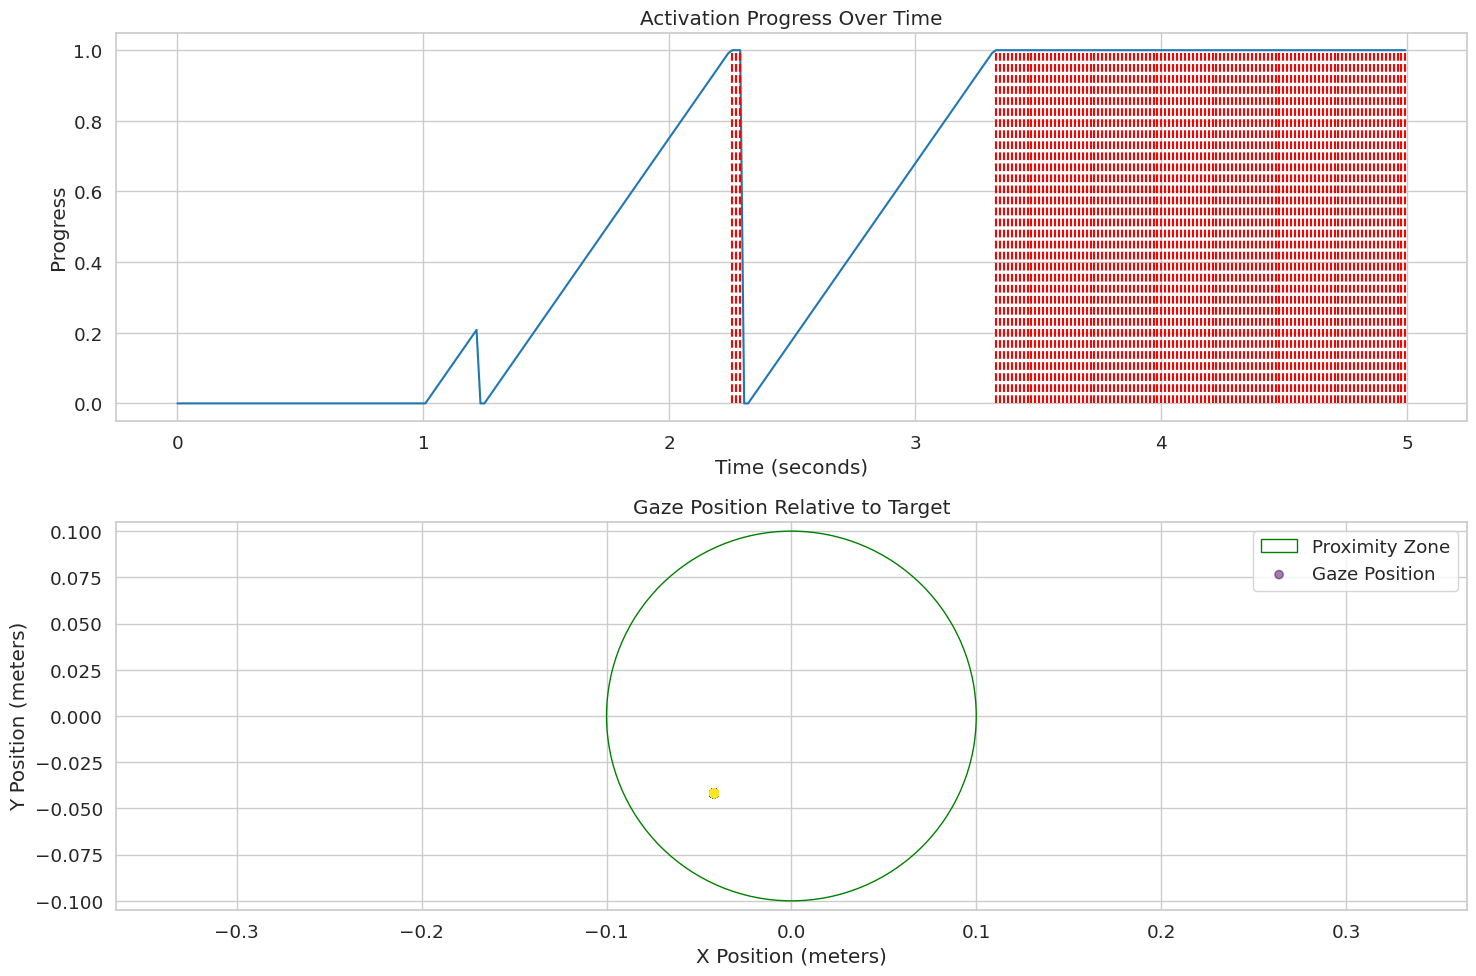

In [18]:
class GazeActivationSystem:
    def __init__(self, proximity_threshold=0.1, dwell_threshold=1.0):
        """
        Initialize the gaze activation system
        proximity_threshold: distance in meters (default 100mm)
        dwell_threshold: time in seconds (default 1.0s)
        """
        self.proximity_threshold = proximity_threshold
        self.dwell_threshold = dwell_threshold
        self.current_dwell_start = None
        self.is_dwelling = False
        self.activation_progress = 0.0
        self.activation_history = []

    def calculate_distance_to_target(self, gaze_position, target_position):
        """Calculate 3D distance between gaze intersection and target"""
        return np.sqrt(
            (gaze_position['x'] - target_position['x'])**2 +
            (gaze_position['y'] - target_position['y'])**2 +
            (gaze_position['z'] - target_position['z'])**2
        )

    def update(self, gaze_position, target_position, current_time):
        """
        Update the activation state based on new gaze data
        Returns: (is_activated, activation_progress)
        """
        # Calculate distance to target
        distance = self.calculate_distance_to_target(gaze_position, target_position)

        # Check if gaze is within proximity threshold
        within_threshold = distance <= self.proximity_threshold

        if within_threshold:
            if not self.is_dwelling:
                # Start new dwell
                self.current_dwell_start = current_time
                self.is_dwelling = True

            # Calculate dwell progress
            dwell_duration = current_time - self.current_dwell_start
            self.activation_progress = min(1.0, dwell_duration / self.dwell_threshold)

            # Check for activation
            if dwell_duration >= self.dwell_threshold:
                self.activation_history.append({
                    'time': current_time,
                    'position': gaze_position,
                    'dwell_duration': dwell_duration
                })
                return True, 1.0
        else:
            # Reset dwell if gaze leaves proximity zone
            self.is_dwelling = False
            self.current_dwell_start = None
            self.activation_progress = 0.0

        return False, self.activation_progress

def demonstrate_activation_system():
    """
    Demonstrate the activation system with visualization
    """
    # Create sample data stream
    sample_rate = 0.016  # ~60Hz
    total_time = 5.0    # 5 seconds of data
    times = np.arange(0, total_time, sample_rate)

    # Initialize system
    activation_system = GazeActivationSystem(proximity_threshold=0.1, dwell_threshold=1.0)

    # Target position
    target_position = {'x': 0, 'y': 0, 'z': 1.0}

    # Simulate gaze movement
    activations = []
    progress_history = []

    for t in times:
        # Simulate gaze position (with some controlled noise)
        # This example simulates looking at target after 1 second
        if t < 1.0:
            # Looking away from target
            gaze_position = {
                'x': 0.2,
                'y': 0.2,
                'z': 1.2
            }
        else:
            # Looking at target with some jitter
            noise = np.random.normal(0, 0.02)  # 20mm standard deviation
            gaze_position = {
                'x': target_position['x'] + noise,
                'y': target_position['y'] + noise,
                'z': target_position['z'] + noise
            }

        # Update system
        is_activated, progress = activation_system.update(gaze_position, target_position, t)

        # Record results
        activations.append(is_activated)
        progress_history.append(progress)

    # Visualize results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot activation progress
    ax1.plot(times, progress_history)
    ax1.set_title('Activation Progress Over Time')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Progress')
    ax1.grid(True)

    # Add activation markers
    activation_times = times[np.where(activations)[0]]
    if len(activation_times) > 0:
        ax1.vlines(activation_times, 0, 1, colors='r', linestyles='dashed', label='Activation')

    # Plot proximity zone
    ax2.add_patch(plt.Circle((0, 0), activation_system.proximity_threshold,
                           fill=False, color='g', label='Proximity Zone'))

    # Plot gaze positions
    gaze_x = [gaze_position['x'] for t in times]
    gaze_y = [gaze_position['y'] for t in times]
    ax2.scatter(gaze_x, gaze_y, c=progress_history, cmap='viridis',
               label='Gaze Position', alpha=0.5)

    ax2.set_title('Gaze Position Relative to Target')
    ax2.set_xlabel('X Position (meters)')
    ax2.set_ylabel('Y Position (meters)')
    ax2.grid(True)
    ax2.axis('equal')
    ax2.legend()

    plt.tight_layout()

    return activation_system.activation_history

# Run demonstration
activation_history = demonstrate_activation_system()